ARIMA EVO

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import funcs_for_proc
from transformator import (
    relative_concentration, get_accepted_maximum_value,
    get_all_relative_concentration)
import warnings
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from itertools import product
from tqdm import tqdm

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
%matplotlib inline
def log_progress(sequence, every=10):
    from ipywidgets import IntProgress
    from IPython.display import display

    progress = IntProgress(min=0, max=len(sequence), value=0)
    display(progress)
    
    for index, record in enumerate(sequence):
        if index % every == 0:
            progress.value = index
        yield record

In [2]:
data = funcs_for_proc.get_data_from_csv('final_data/data_train/data_train', 'csv','final_data/train.csv')


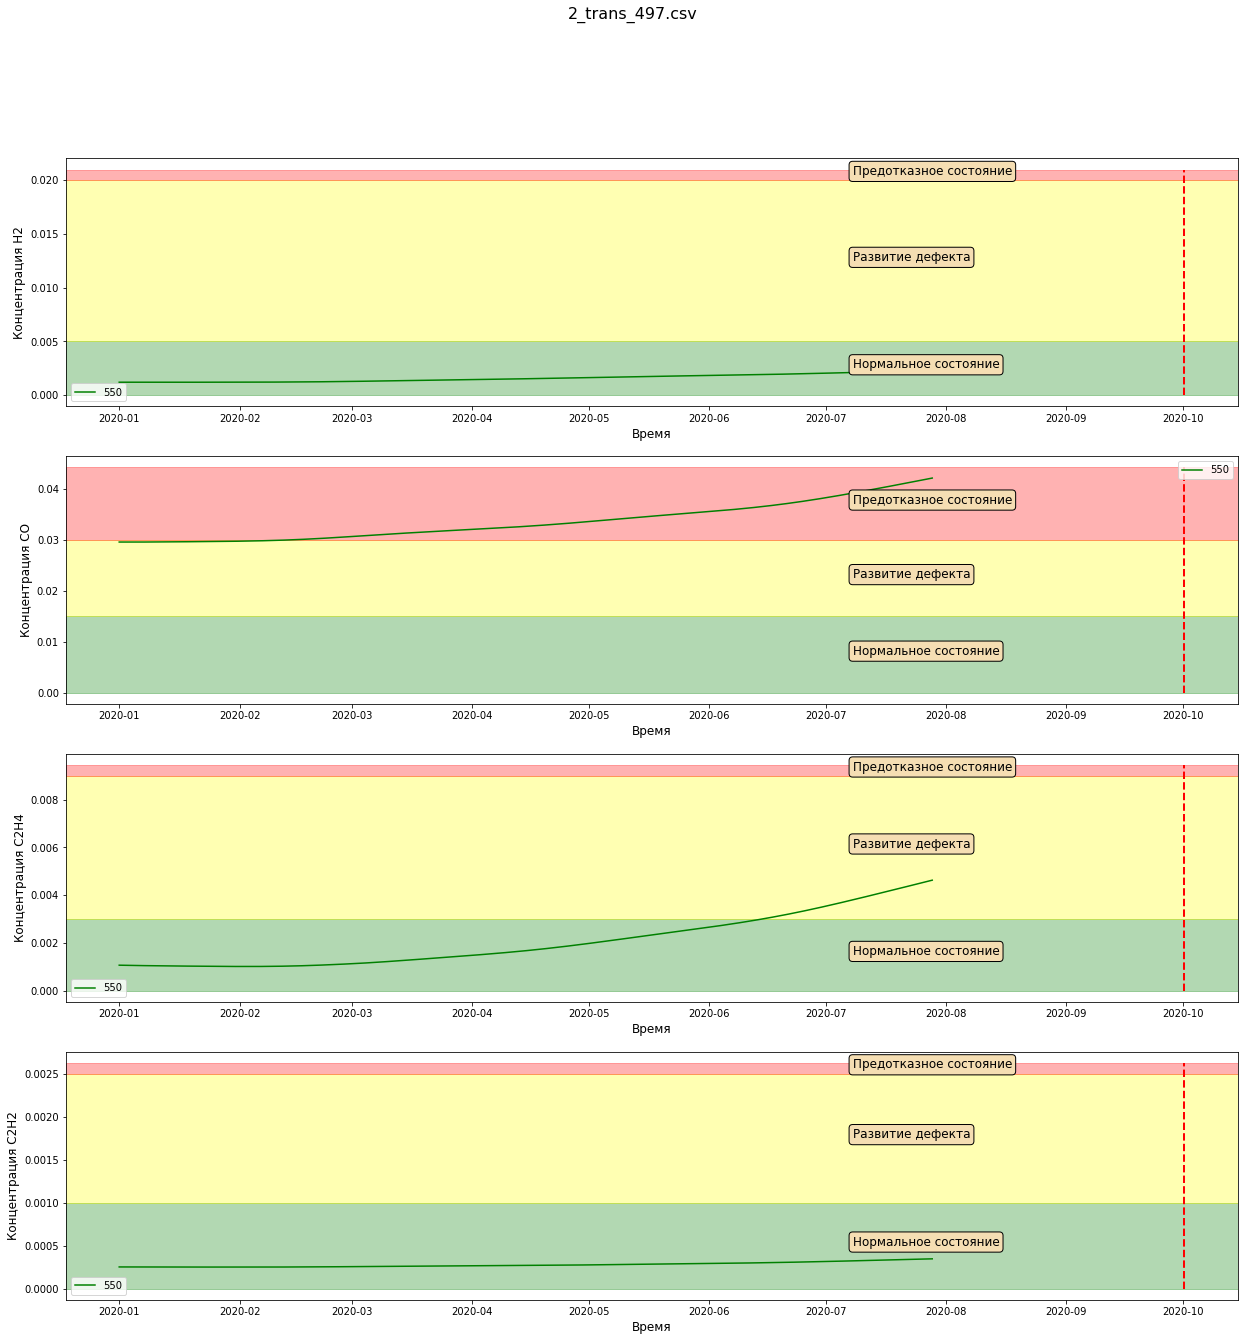

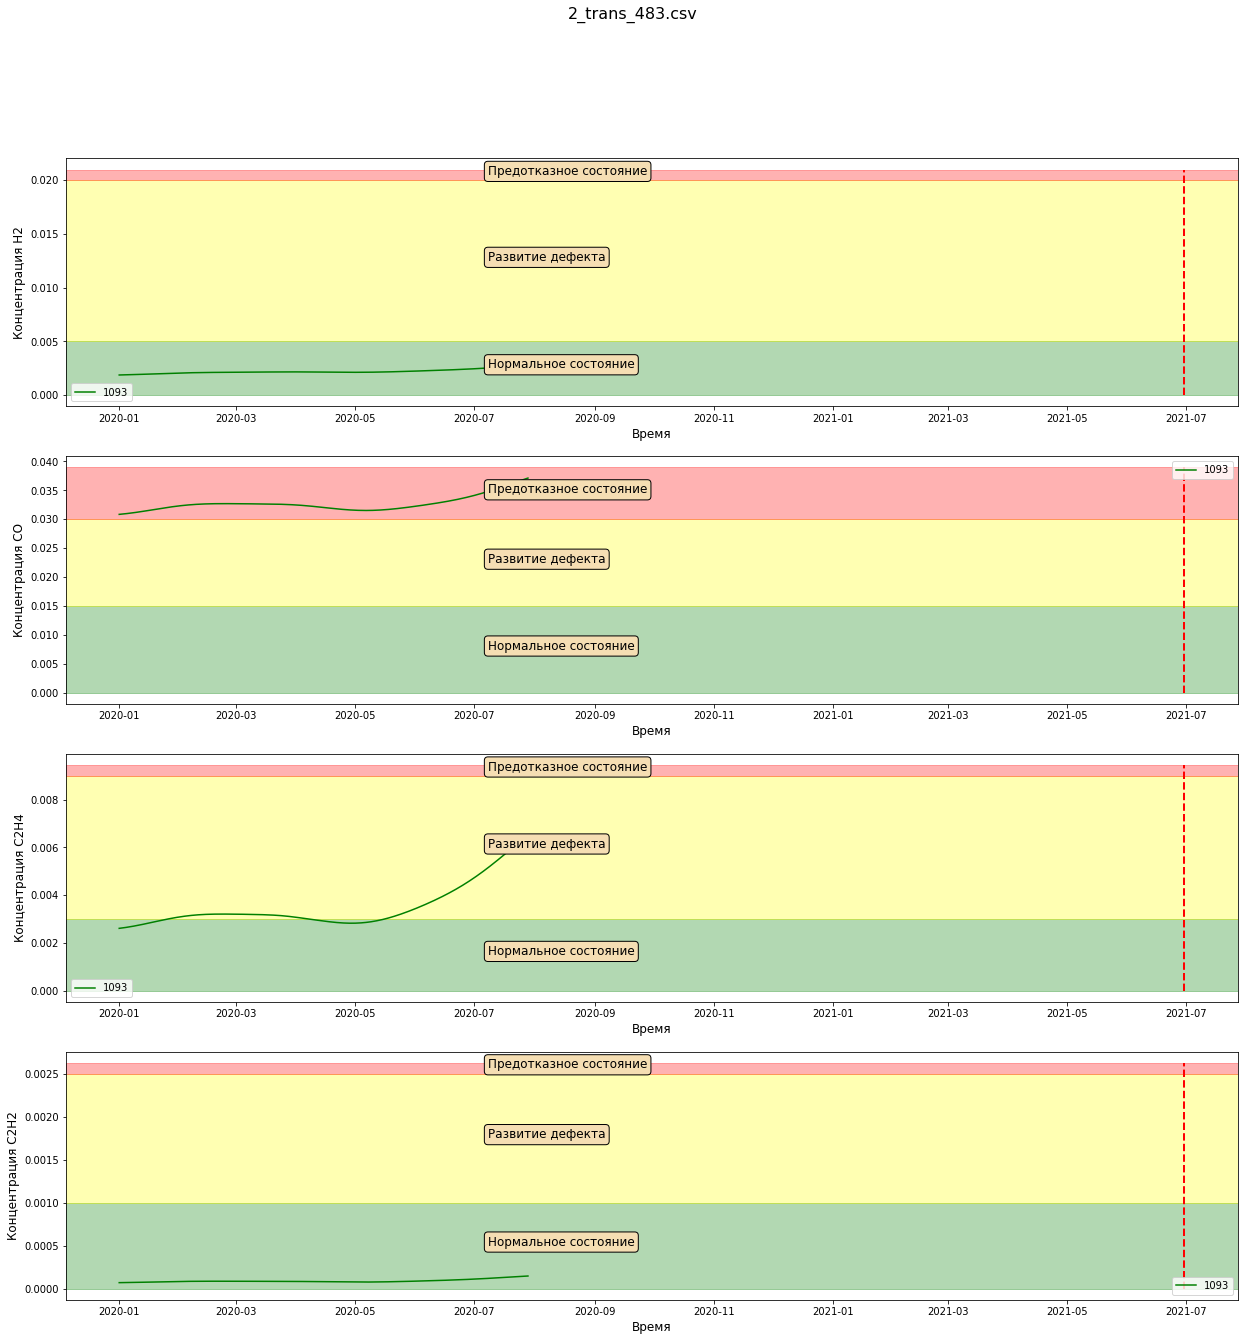

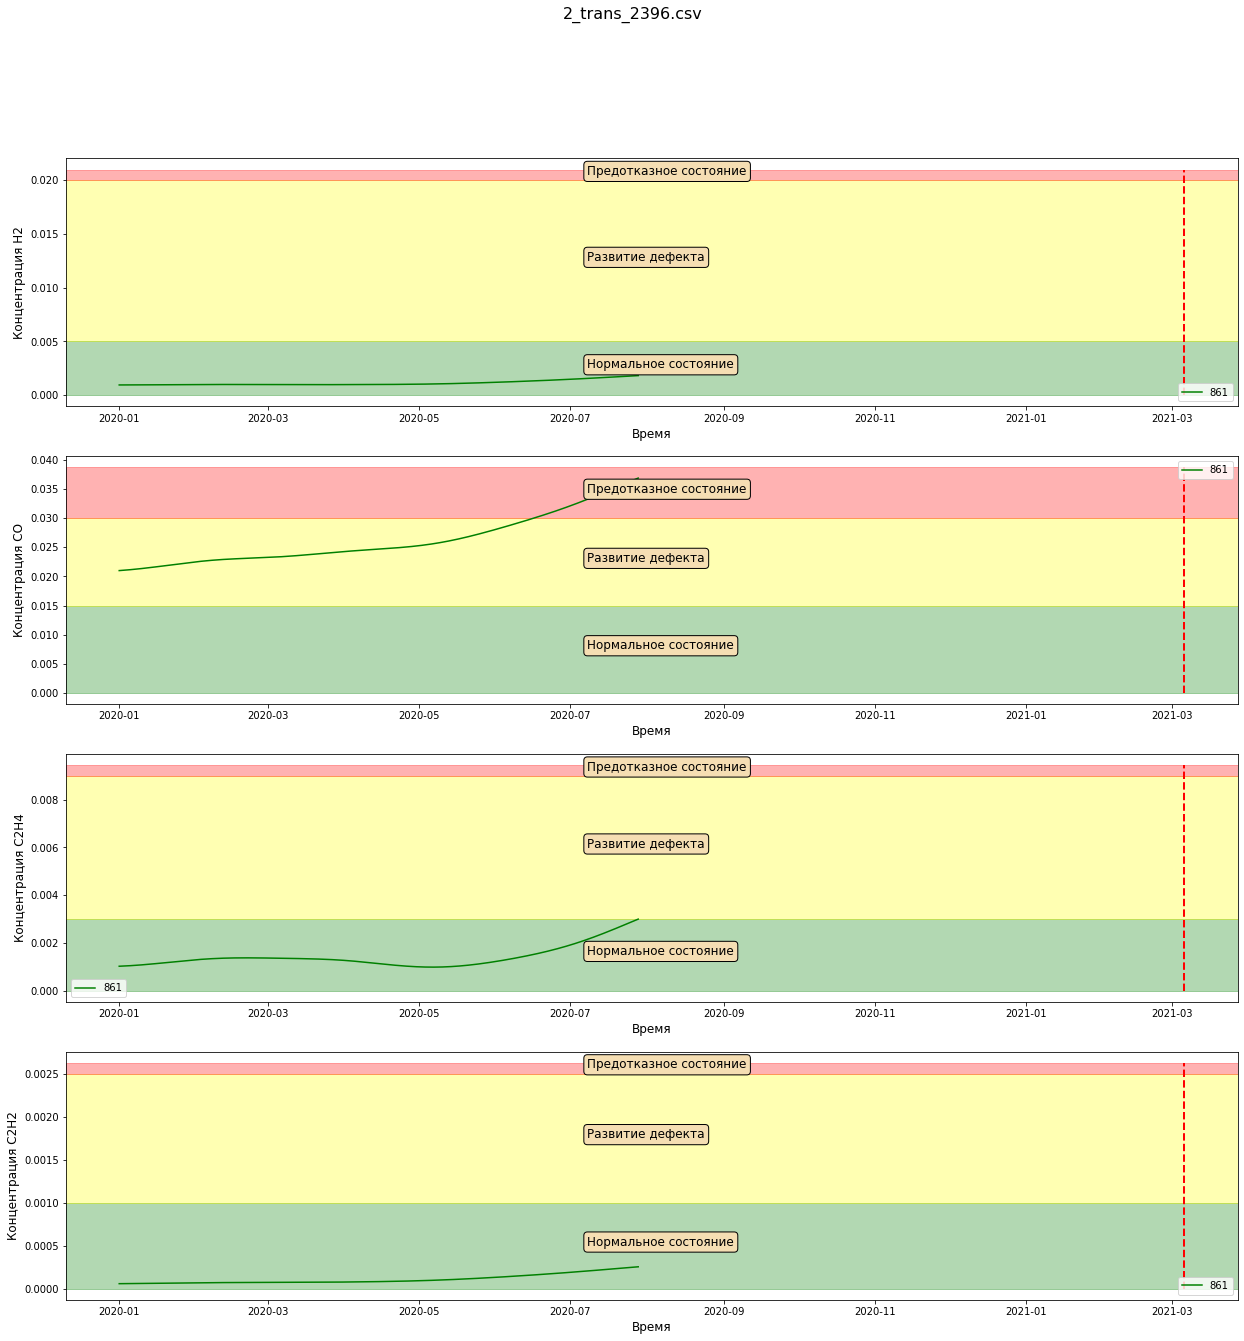

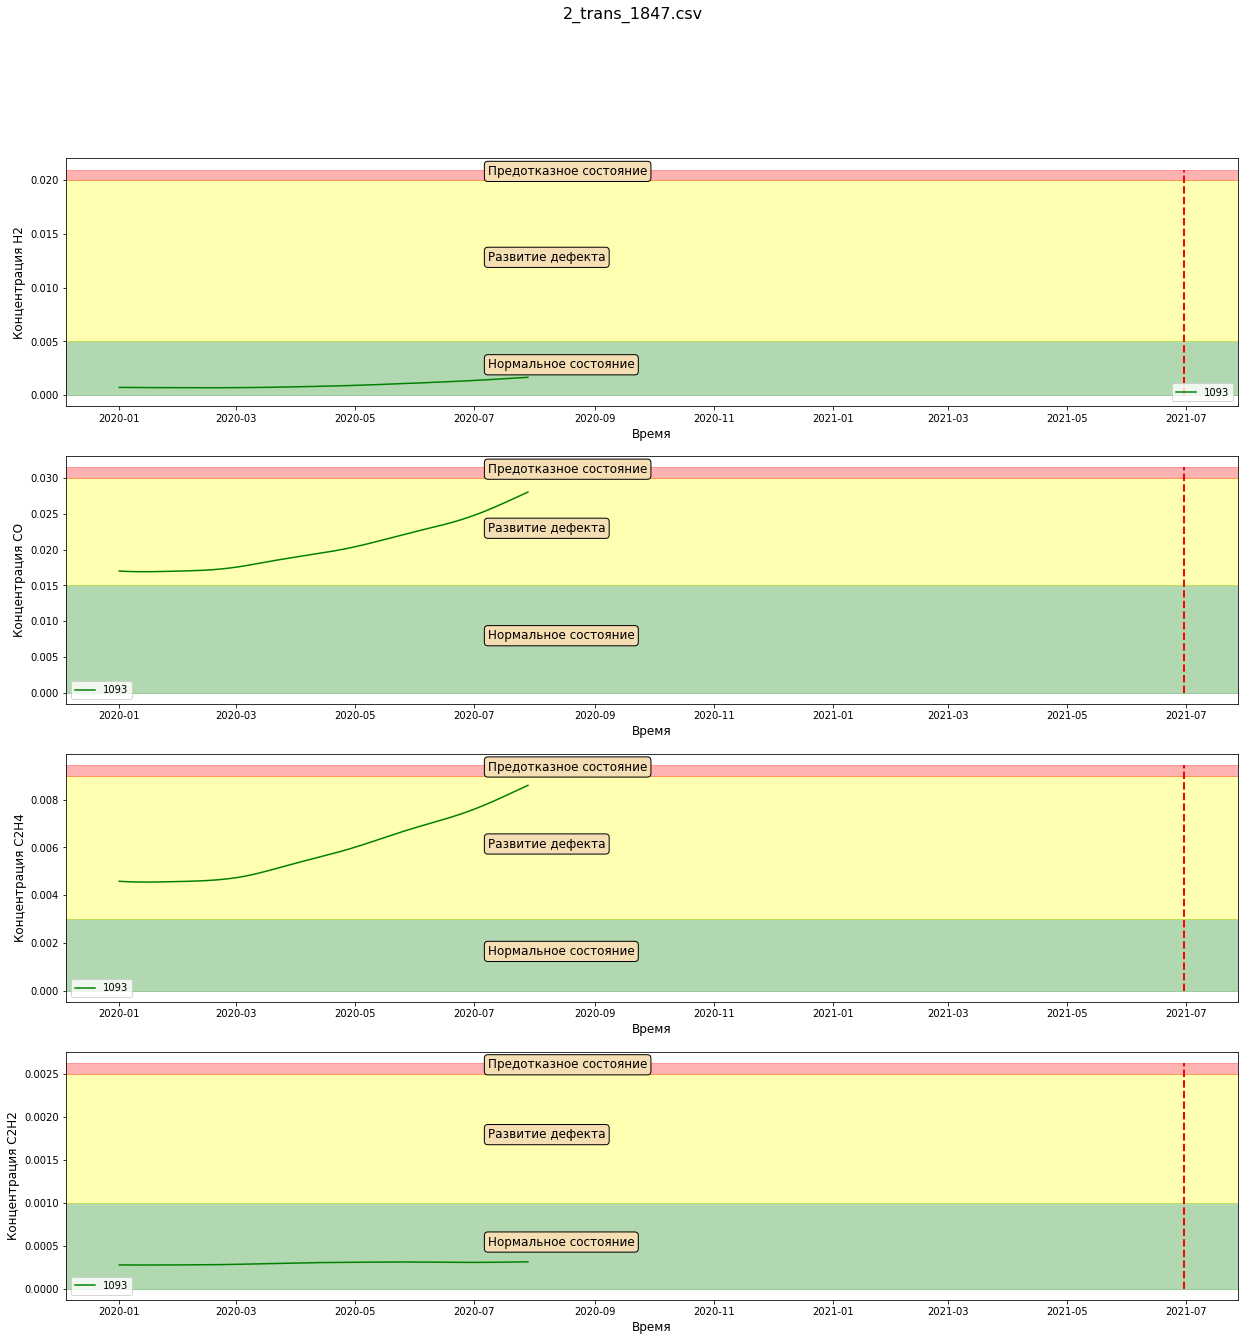

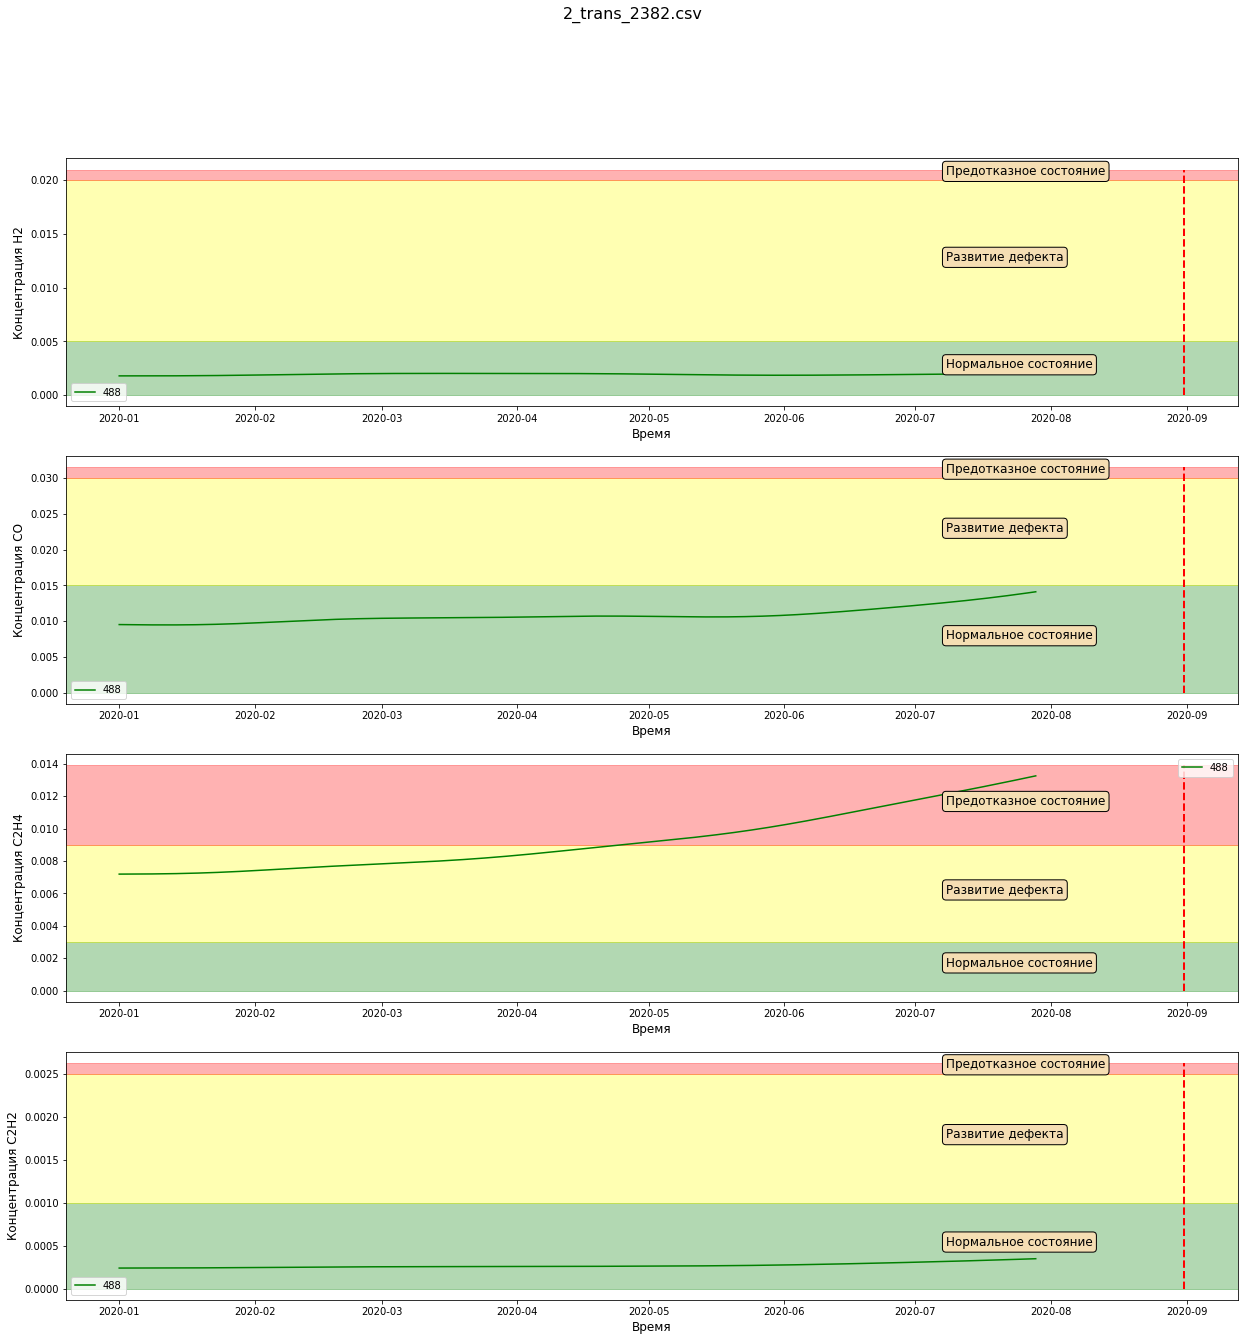

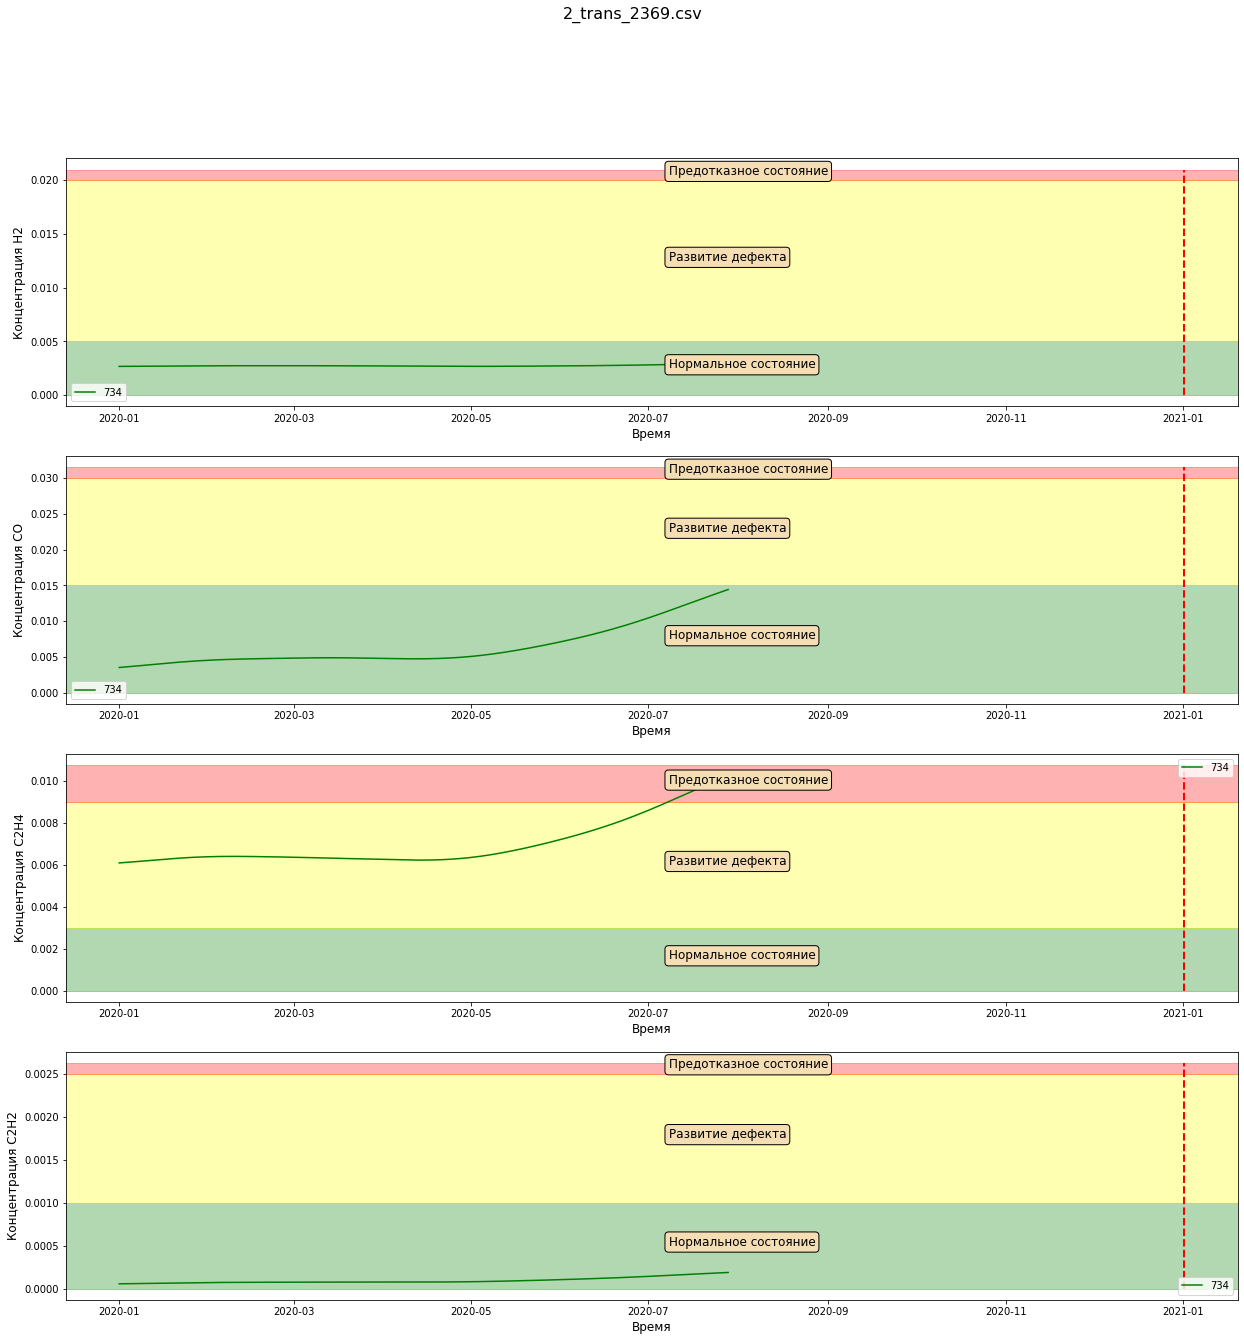

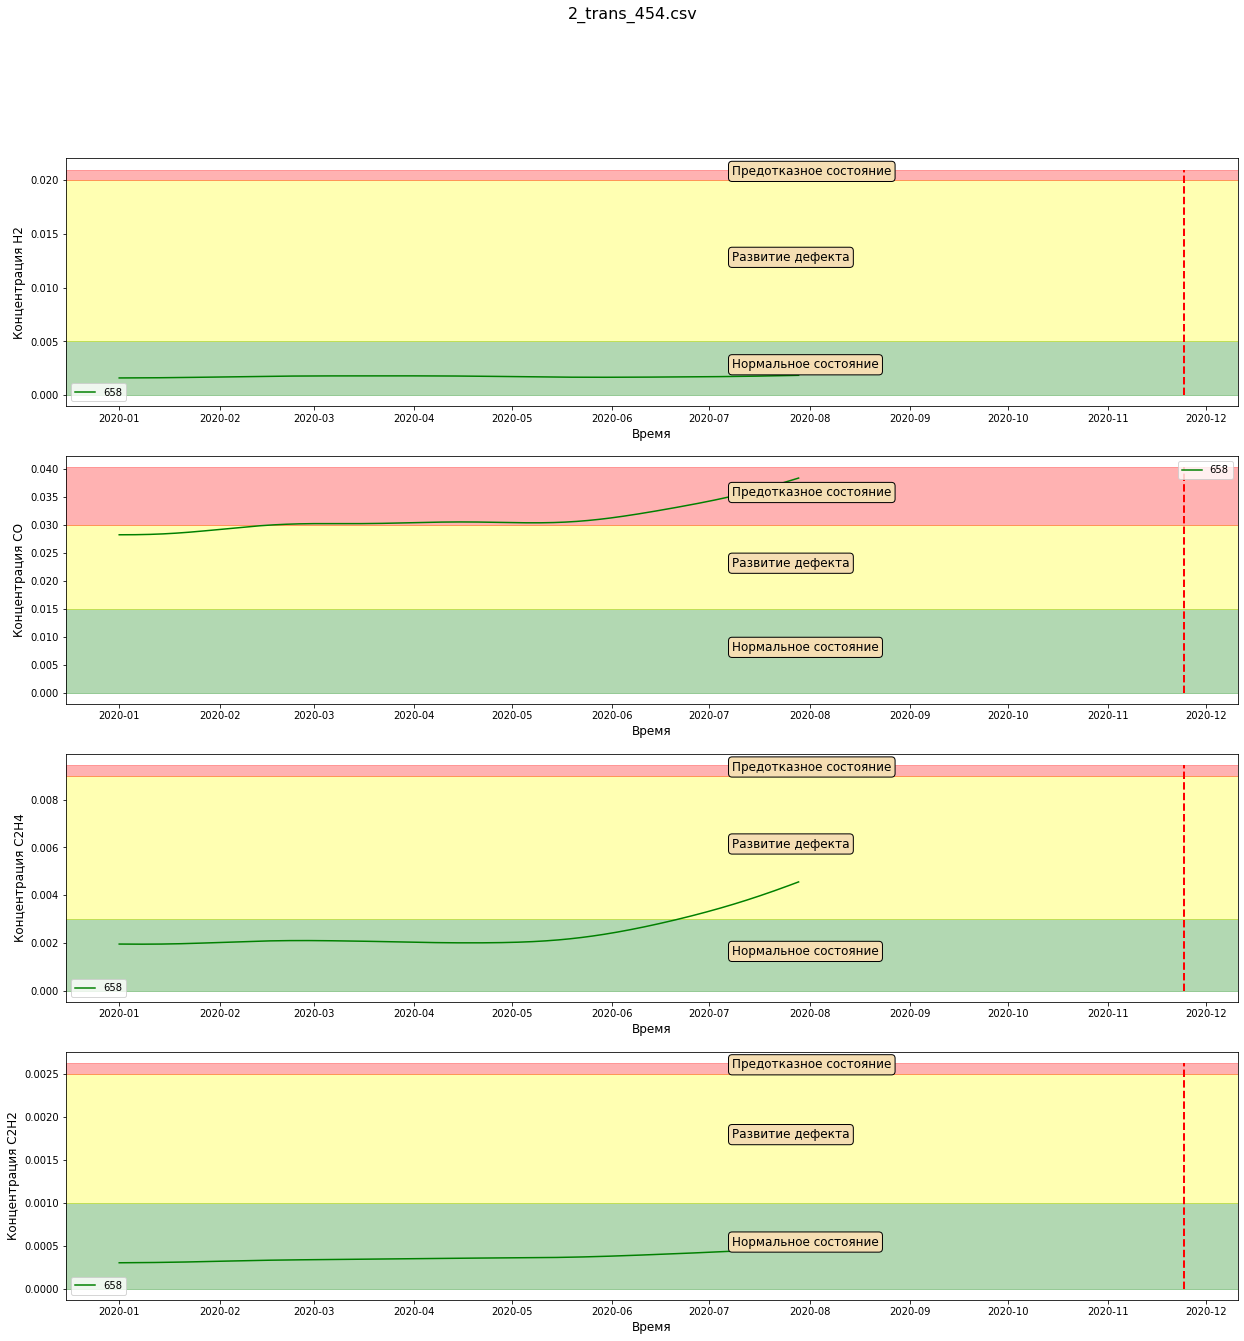

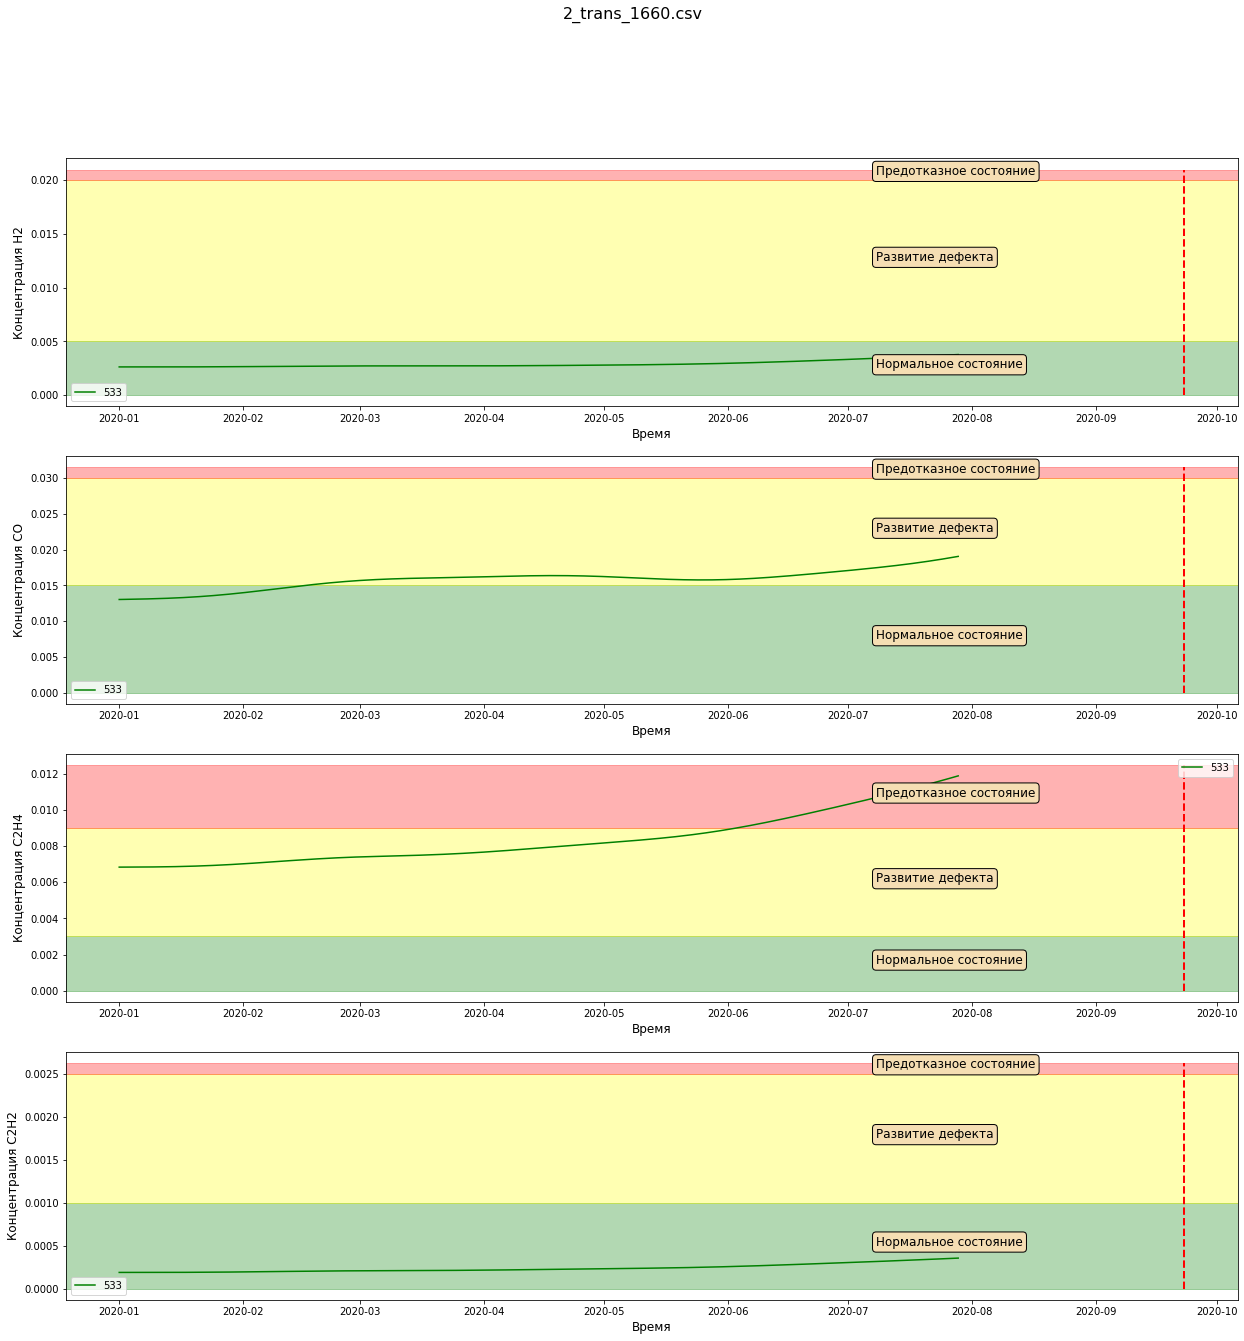

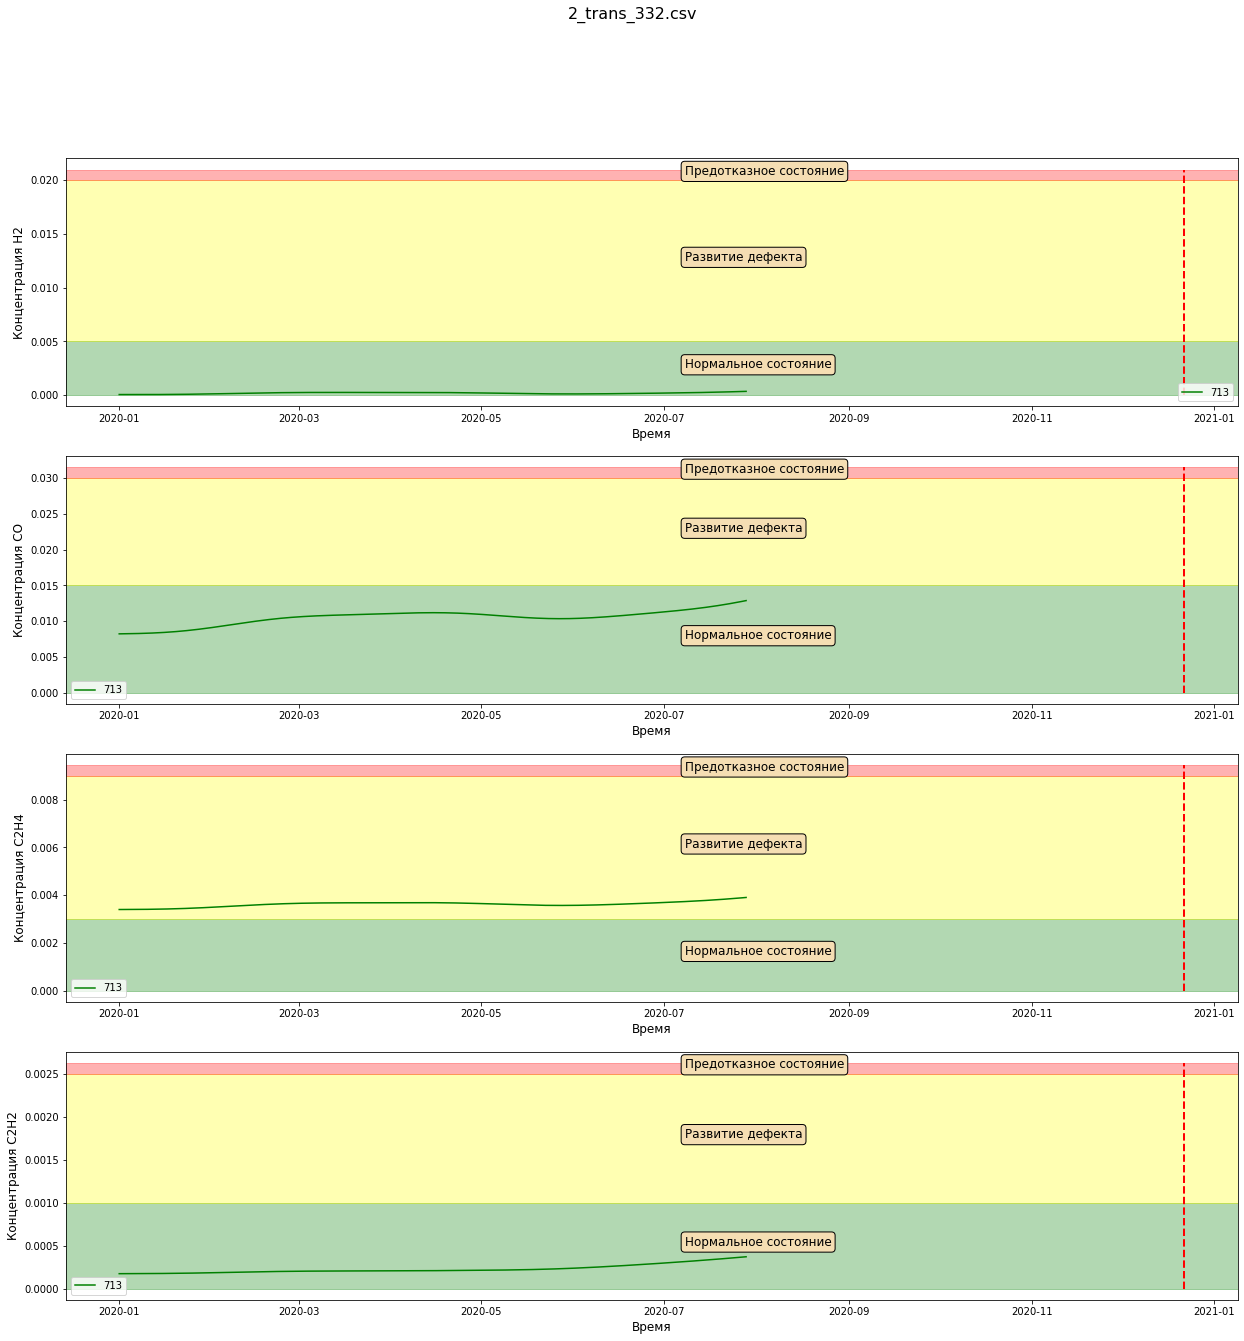

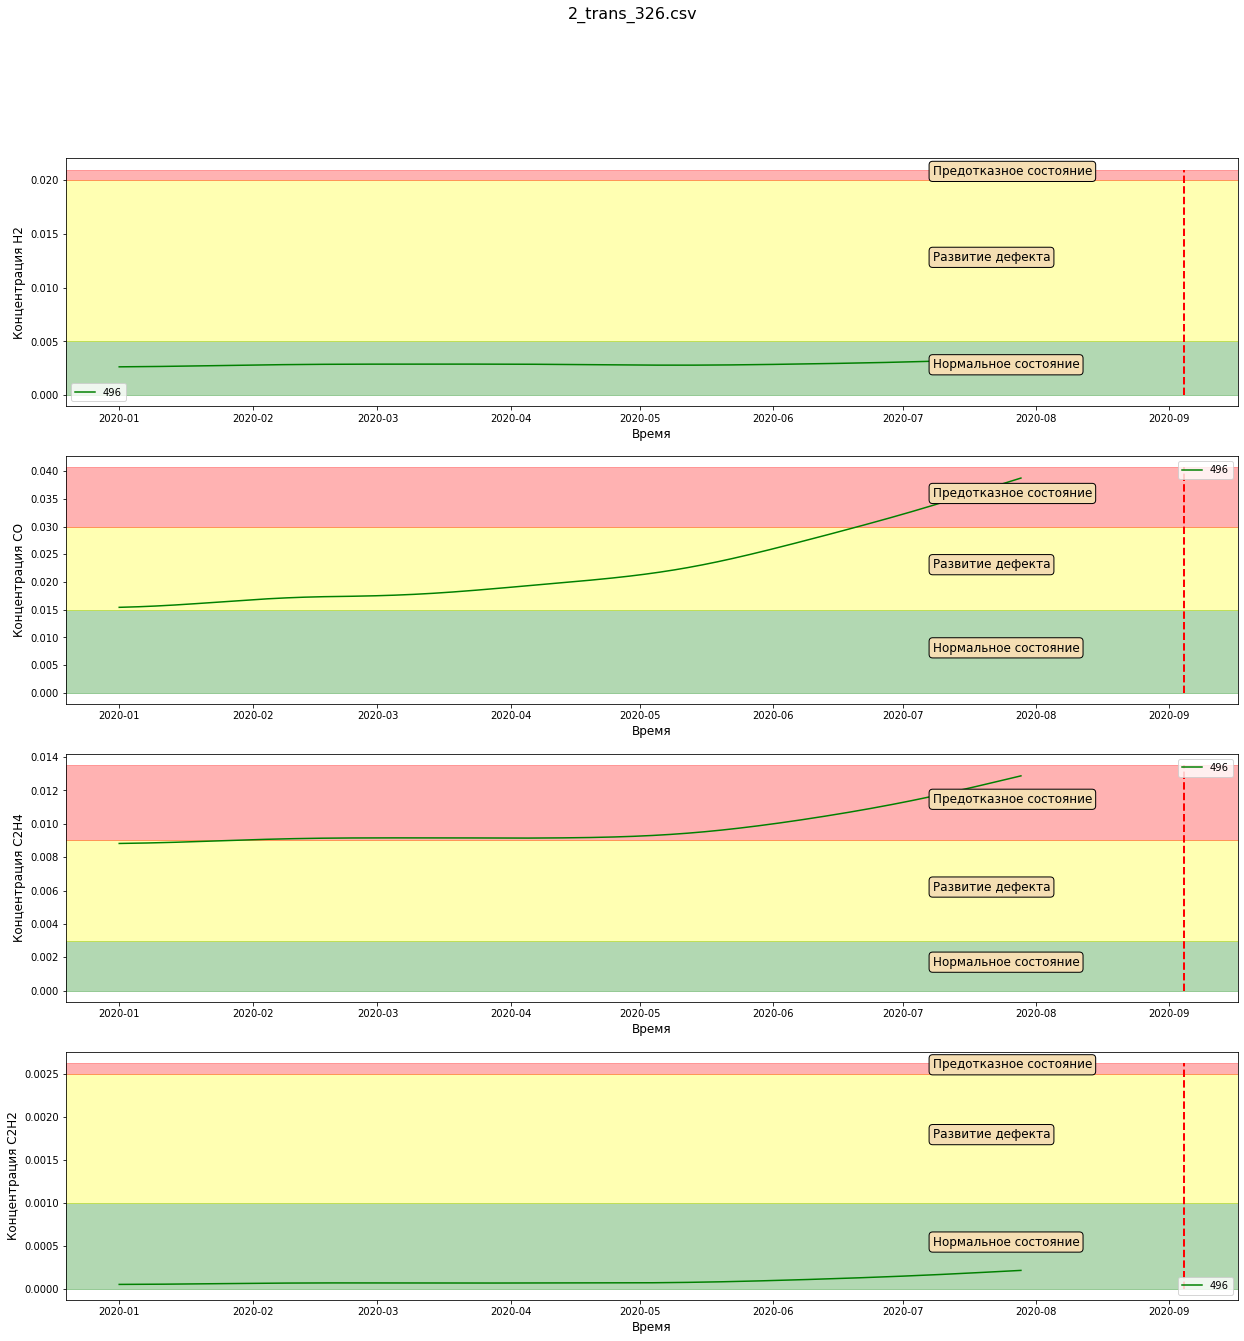

In [3]:
props = dict(boxstyle='round', facecolor='wheat', alpha=1)
for file in data[:10]:
    fig, ax = plt.subplots(4, 1, figsize=(21, 21))
    fig.suptitle(file[0], fontsize=16)
    data_normal=file[2]
    pred=file[1]
    for i, gas in enumerate(['H2', 'CO', 'C2H4', 'C2H2']):
        datetime_pred= pd.date_range("2020-01-01", periods=pred, freq='12H')
        accepted_level = get_accepted_maximum_value(gas, 0, '35kW')[0]
        maximum_level = get_accepted_maximum_value(gas, 0, '35kW')[1]
        max_axhspan_level = max(data_normal[gas].max(),maximum_level)*1.05

        max_text_level = (max_axhspan_level - maximum_level) / 2 + maximum_level
        accepted_text_level = (maximum_level - accepted_level) / 2 + accepted_level
        normal_text_level = accepted_level / 2
        text_egle = round(len(data_normal.index) * 0.90) 
        # Графики
        ax[i].vlines(datetime_pred[-1], 0, max_axhspan_level,
          color = 'r',
          linewidth = 2,
          linestyle = '--')
        ax[i].plot(data_normal.index, data_normal[gas], label=pred, color='green') 
        # Зоны
        ax[i].axhspan(0, accepted_level, facecolor='1', color='green', alpha=0.3)
        ax[i].axhspan(accepted_level, maximum_level, facecolor='1', color='yellow', alpha=0.3)
        ax[i].axhspan(maximum_level, max_axhspan_level, facecolor='1', color='red', alpha=0.3)
#         Текст
        ax[i].text(data_normal.index[text_egle], max_text_level, "Предотказное состояние", fontsize=12, color='black',
                  bbox=props)
        ax[i].text(data_normal.index[text_egle], accepted_text_level, "Развитие дефекта", fontsize=12, color='black',
                  bbox=props)
        ax[i].text(data_normal.index[text_egle], normal_text_level, "Нормальное состояние", fontsize=12, color='black',
                  bbox=props)
        ax[i].set_xlabel("Время", fontsize=12)
        ax[i].set_ylabel(f'Концентрация {gas}', fontsize=12)
        ax[i].legend()

    plt.show()

Dickey-Fuller test H2 (1.3609304927984347, 0.9969292222118249, 12, 407, {'1%': -3.4465195891135845, '5%': -2.8686676281678634, '10%': -2.5705668101226085}, -15483.19502748322)


<Figure size 1512x1512 with 0 Axes>

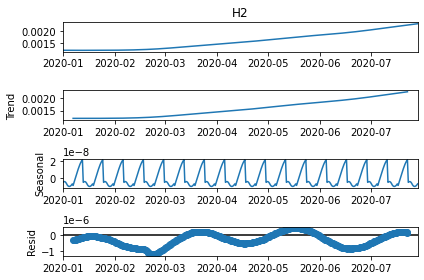

Dickey-Fuller test CO (4.498796884968343, 1.0, 5, 414, {'1%': -3.4462444670071046, '5%': -2.8685466682709975, '10%': -2.5705023309762187}, -13487.37983381879)


<Figure size 1512x1512 with 0 Axes>

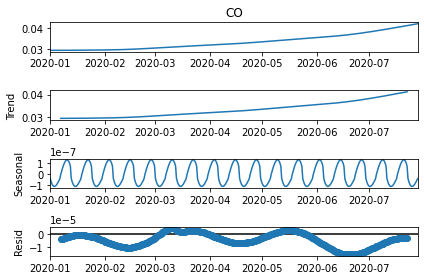

Dickey-Fuller test C2H4 (1.2988436513930508, 0.9966024536151104, 3, 416, {'1%': -3.4461675720270404, '5%': -2.8685128587855955, '10%': -2.5704843086630915}, -14436.57039198283)


<Figure size 1512x1512 with 0 Axes>

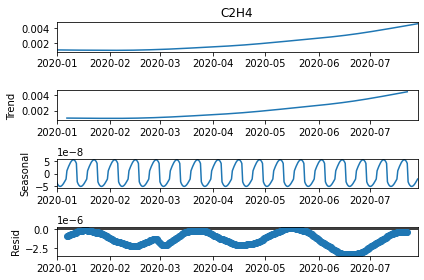

Dickey-Fuller test C2H2 (3.2458114598952976, 1.0, 5, 414, {'1%': -3.4462444670071046, '5%': -2.8685466682709975, '10%': -2.5705023309762187}, -17244.67830329566)


<Figure size 1512x1512 with 0 Axes>

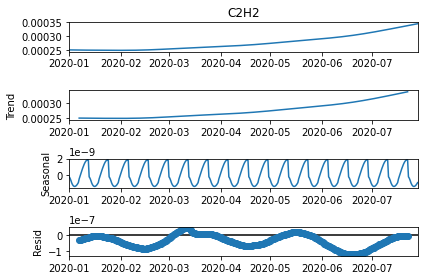

In [4]:
for file in data[:1]:
    data_normal=file[2]
    pred=file[1]
    for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
        plt.figure(figsize=(21, 21))
        print("Dickey-Fuller test %s" %gas,sm.tsa.stattools.adfuller(data_normal[gas]))
        sm.tsa.seasonal_decompose(data_normal[gas]).plot()
        plt.show()


Dickey-Fuller test H2  0.358061
unstat


<Figure size 1512x1512 with 0 Axes>

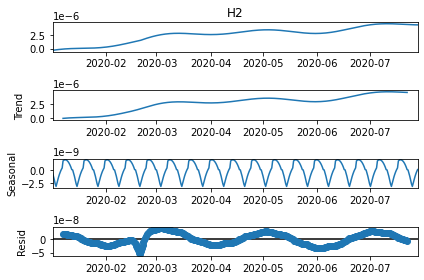

Dickey-Fuller test CO  0.979726
unstat


<Figure size 1512x1512 with 0 Axes>

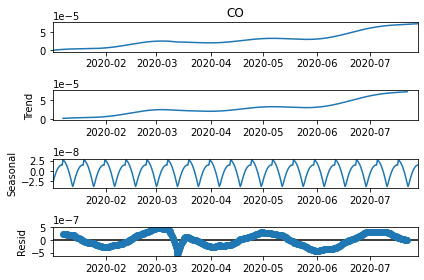

Dickey-Fuller test C2H4  0.874167
unstat


<Figure size 1512x1512 with 0 Axes>

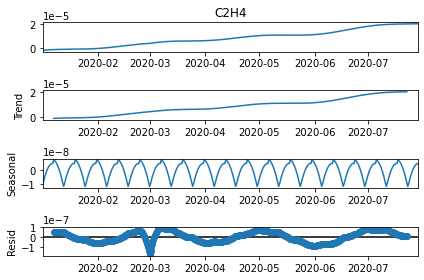

Dickey-Fuller test C2H2  0.939054
unstat


<Figure size 1512x1512 with 0 Axes>

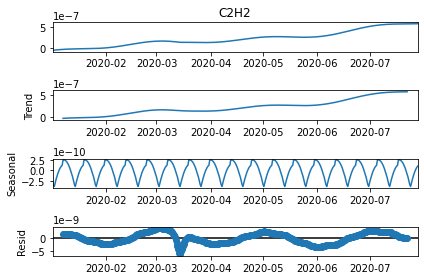

In [5]:
for file in data[:1]:
    data_normal=file[2].diff(periods=1).dropna()
    pred=file[1]
    for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
        plt.figure(figsize=(21, 21))
        restest=sm.tsa.stattools.adfuller(data_normal[gas])
        print("Dickey-Fuller test %s  %f" %(gas,restest[1]))
        if restest[0]> restest[4]['5%']: 
            print ('unstat')
        else:
            print('stat')
        sm.tsa.seasonal_decompose(data_normal[gas]).plot()
        plt.show()



Dickey-Fuller test H2  0.008858
stat


<Figure size 1512x1512 with 0 Axes>

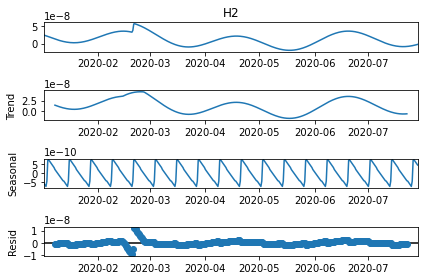

Dickey-Fuller test CO  0.037565
stat


<Figure size 1512x1512 with 0 Axes>

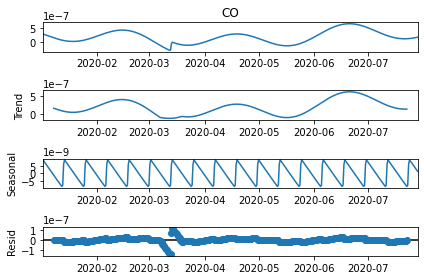

Dickey-Fuller test C2H4  0.194479
unstat


<Figure size 1512x1512 with 0 Axes>

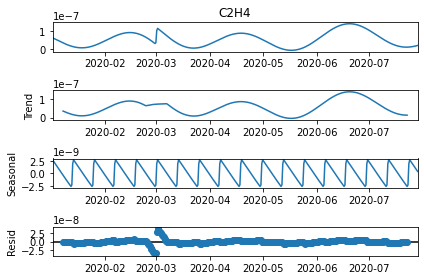

Dickey-Fuller test C2H2  0.037576
stat


<Figure size 1512x1512 with 0 Axes>

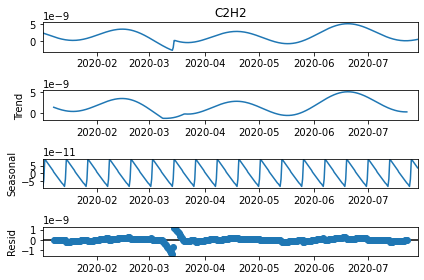

In [6]:
for file in data[:1]:
    data_normal=file[2].diff().dropna().diff().dropna()
    pred=file[1]
    for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
        plt.figure(figsize=(21, 21))
        restest=sm.tsa.stattools.adfuller(data_normal[gas])
        print("Dickey-Fuller test %s  %f" %(gas,restest[1]))
        if restest[0]> restest[4]['5%']: 
            print ('unstat')
        else:
            print('stat')
        sm.tsa.seasonal_decompose(data_normal[gas]).plot()
        plt.show()



In [7]:
file=data[30]
data_normal=file[2]
mindfGas=pd.DataFrame()
model_res={}
for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
    print('----------------------------------------------------\nGAS %s'%gas)
    df=pd.DataFrame(columns=['aic','param','param_seasonal'])
    p  = q = range(0, 2)
    d=[2]
    pdq = list(product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 1) for x in pdq]
    warnings.filterwarnings("ignore") 
    aics=[]
    params=[]
    param_seasonals=[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data_normal[gas],
                                                order=param,
                                                
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                aics.append(results.aic)
                params.append(param)
                param_seasonals.append(param_seasonal)
            except BaseException as e :
                continue
    df=pd.DataFrame({'aic':aics,'param':params,'param_seasonal':param_seasonals})
    minaic_param=df[df.aic == df.aic.min()].iloc[[0]]
    print(minaic_param)
    print(minaic_param.param.values,minaic_param.param_seasonal.values)
    mod = sm.tsa.statespace.SARIMAX(data_normal[gas],
                                order=minaic_param.param.values[0],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    model_res[gas] = mod.fit()

    print(model_res[gas].summary().tables[1])

----------------------------------------------------
GAS H2
ARIMA(0, 2, 0)x(0, 2, 0, 1) - AIC:-8101.072434153638
ARIMA(0, 2, 0)x(0, 2, 1, 1) - AIC:-8101.072434153638
ARIMA(0, 2, 0)x(1, 2, 0, 1) - AIC:-8101.072434153638
ARIMA(0, 2, 0)x(1, 2, 1, 1) - AIC:-8101.072434153638
ARIMA(0, 2, 1)x(0, 2, 0, 1) - AIC:-8130.261786951936
ARIMA(0, 2, 1)x(0, 2, 1, 1) - AIC:-8130.261786951936
ARIMA(0, 2, 1)x(1, 2, 0, 1) - AIC:-8130.261786951936
ARIMA(0, 2, 1)x(1, 2, 1, 1) - AIC:-8130.261786951936
ARIMA(1, 2, 0)x(0, 2, 0, 1) - AIC:-8123.043341739482
ARIMA(1, 2, 0)x(0, 2, 1, 1) - AIC:-8123.043341739482
ARIMA(1, 2, 0)x(1, 2, 0, 1) - AIC:-8123.043341739482
ARIMA(1, 2, 0)x(1, 2, 1, 1) - AIC:-8123.043341739482
ARIMA(1, 2, 1)x(0, 2, 0, 1) - AIC:-7327.0875587114215
ARIMA(1, 2, 1)x(0, 2, 1, 1) - AIC:-7327.0875587114215
ARIMA(1, 2, 1)x(1, 2, 0, 1) - AIC:-7327.0875587114215
ARIMA(1, 2, 1)x(1, 2, 1, 1) - AIC:-7327.0875587114215
           aic      param param_seasonal
4 -8130.261787  (0, 2, 1)   (0, 2, 0, 1)
[(0, 2

----------------------------------------------------
GAS H2


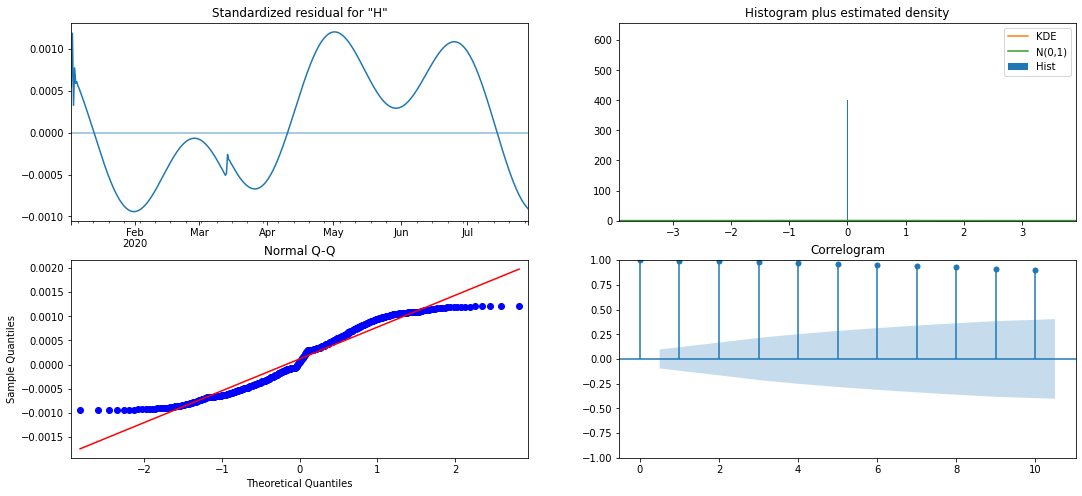

----------------------------------------------------
GAS CO


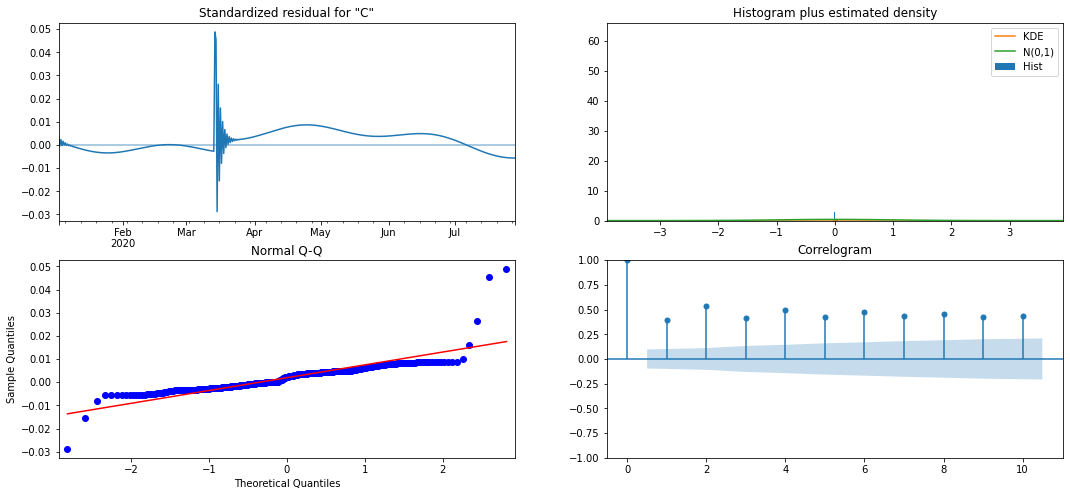

----------------------------------------------------
GAS C2H4


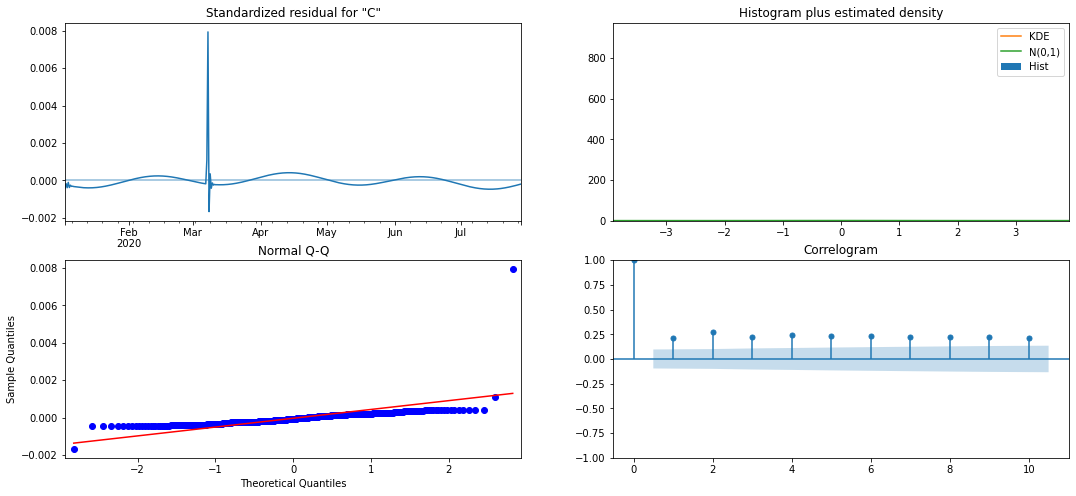

----------------------------------------------------
GAS C2H2


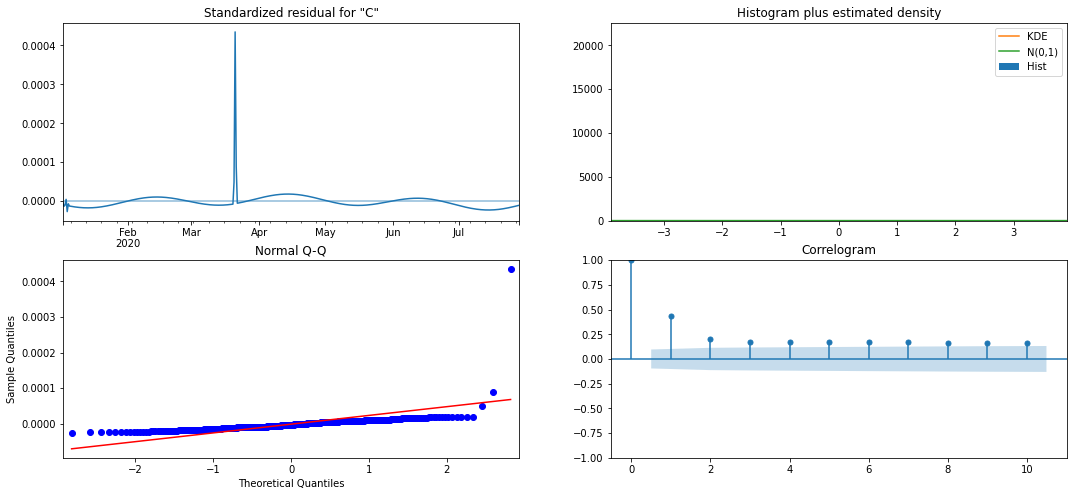

In [8]:
for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
    print('----------------------------------------------------\nGAS %s'%gas)
    model_res[gas].plot_diagnostics(figsize=(18, 8))
    model_forecast=model_res[gas]
    plt.show()

----------------------------------------------------
GAS H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 1.16e-08
----------------------------------------------------
GAS CO
The Mean Squared Error is 0.0
The Root Mean Squared Error is 1.459e-07
----------------------------------------------------
GAS C2H4
The Mean Squared Error is 0.0
The Root Mean Squared Error is 3.29e-08
----------------------------------------------------
GAS C2H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 1.3e-09


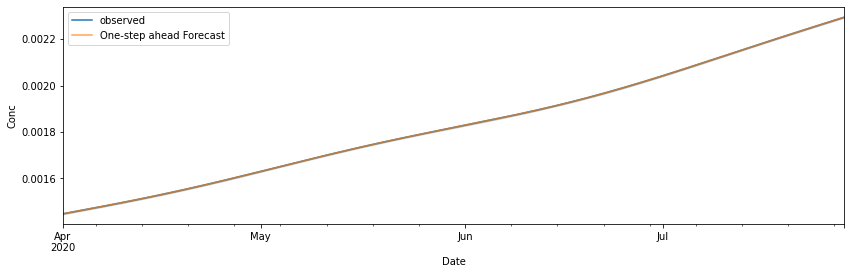

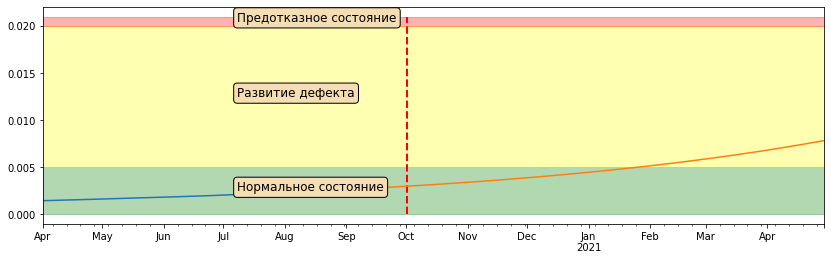

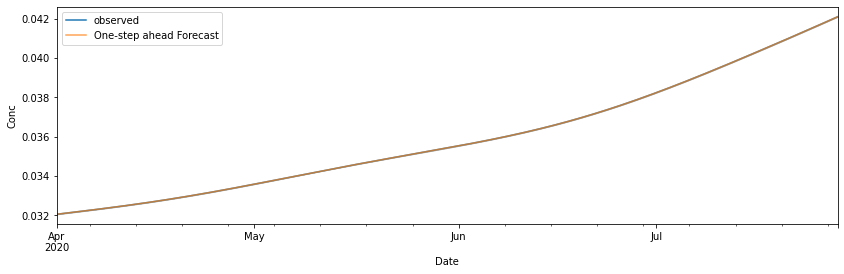

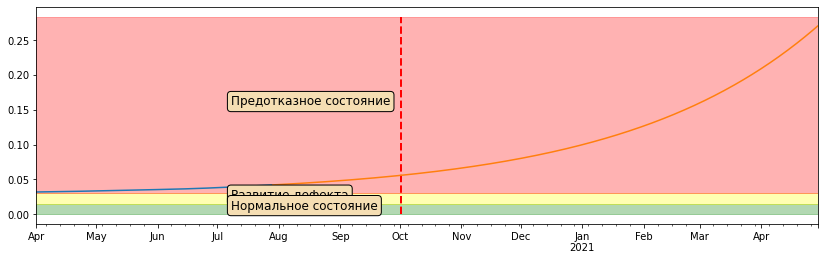

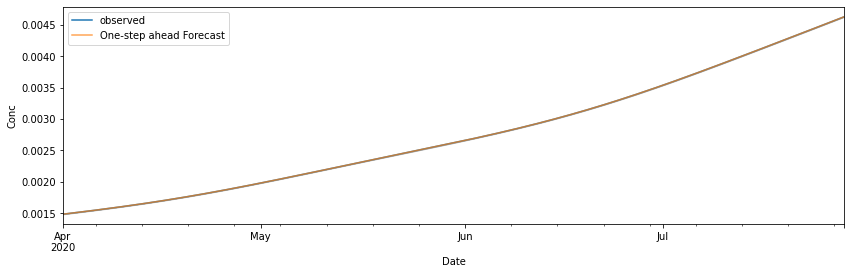

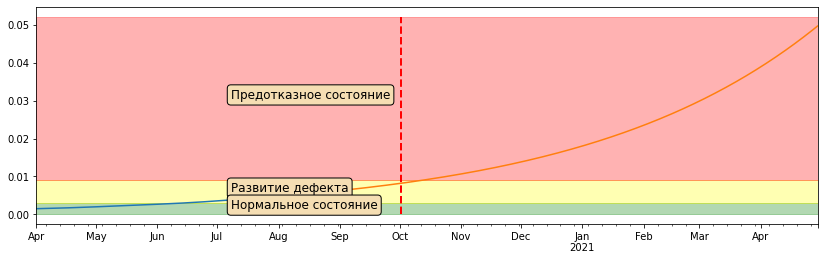

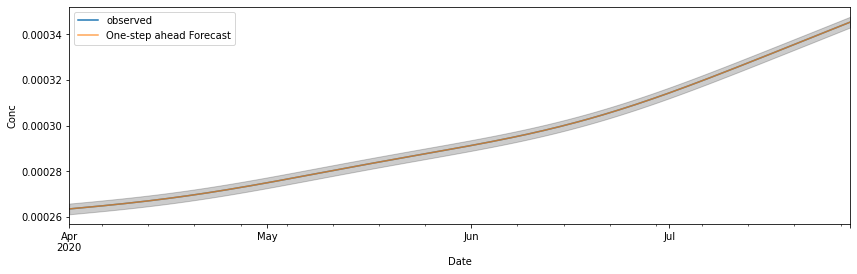

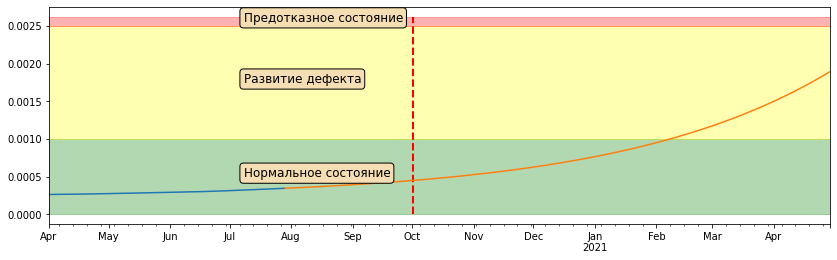

----------------------------------------------------
GAS H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 2.51e-08
----------------------------------------------------
GAS CO
The Mean Squared Error is 0.0
The Root Mean Squared Error is 3.798e-07
----------------------------------------------------
GAS C2H4
The Mean Squared Error is 0.0
The Root Mean Squared Error is 1.615e-07
----------------------------------------------------
GAS C2H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 3.926e-07


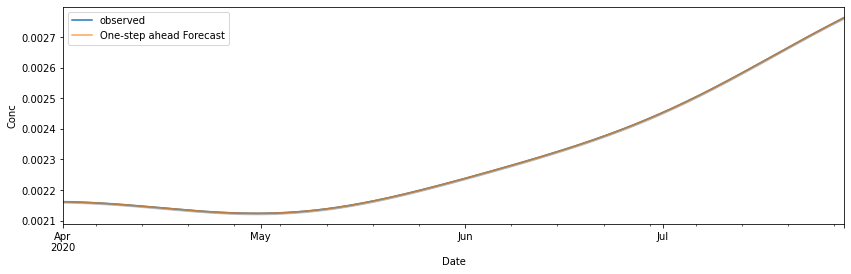

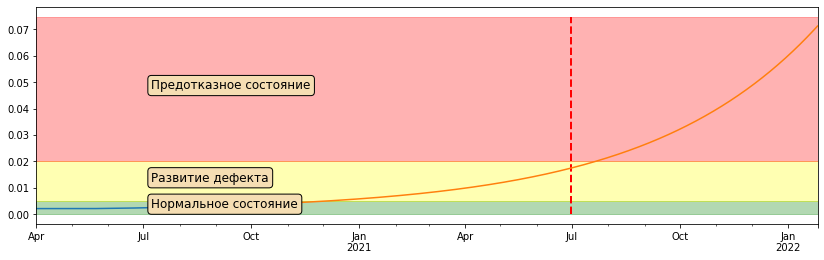

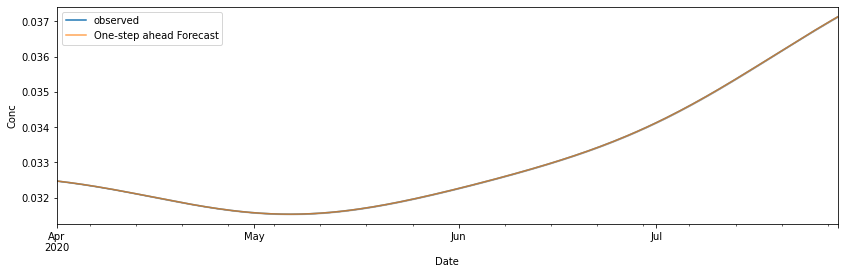

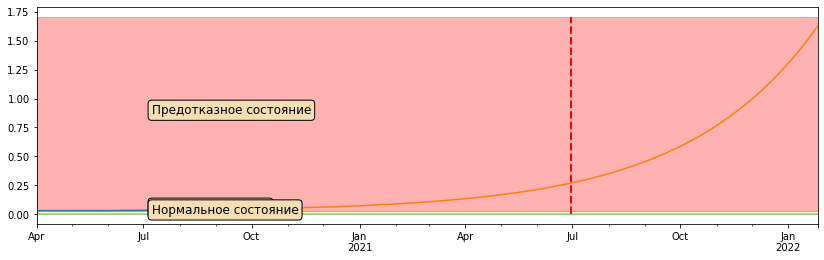

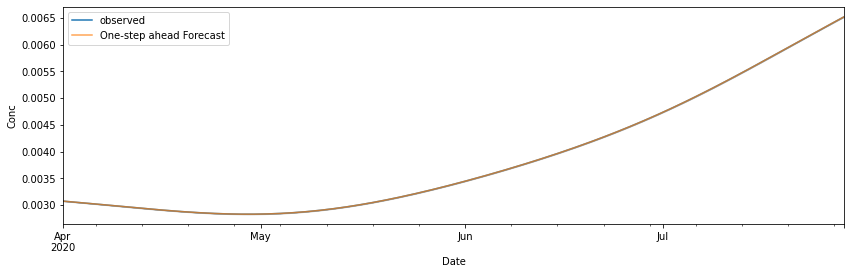

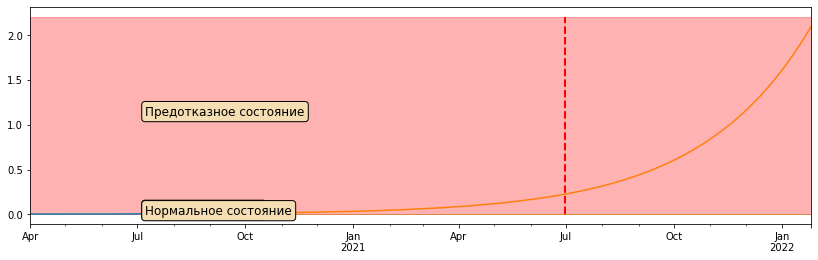

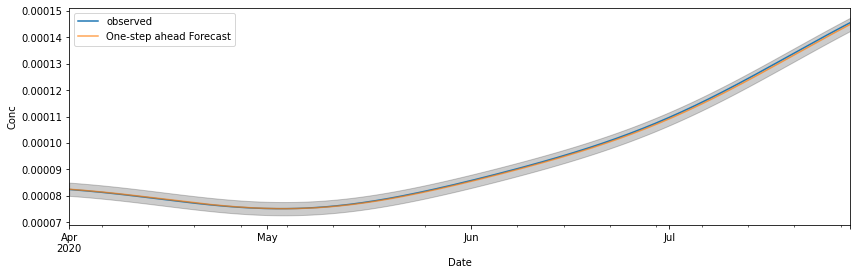

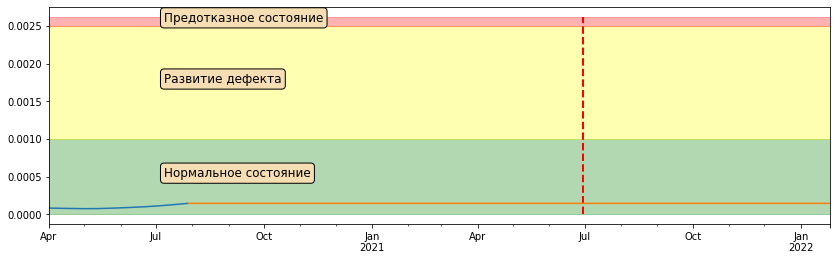

----------------------------------------------------
GAS H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 2.03e-08
----------------------------------------------------
GAS CO
The Mean Squared Error is 0.0
The Root Mean Squared Error is 3.04e-07
----------------------------------------------------
GAS C2H4
The Mean Squared Error is 0.0
The Root Mean Squared Error is 7.31e-08
----------------------------------------------------
GAS C2H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 3.5e-09


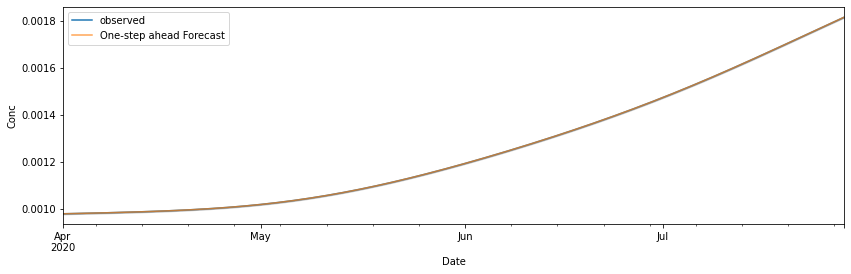

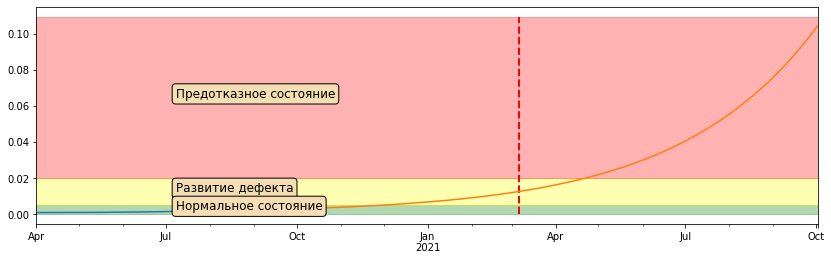

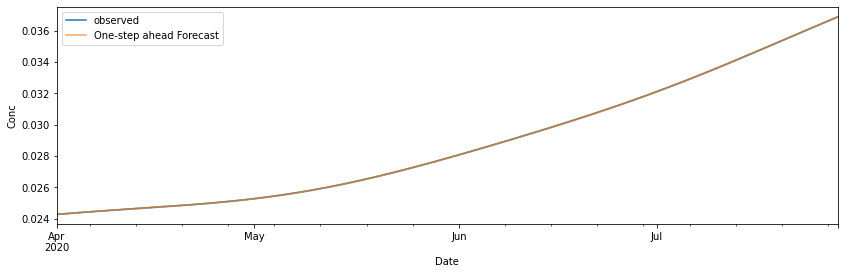

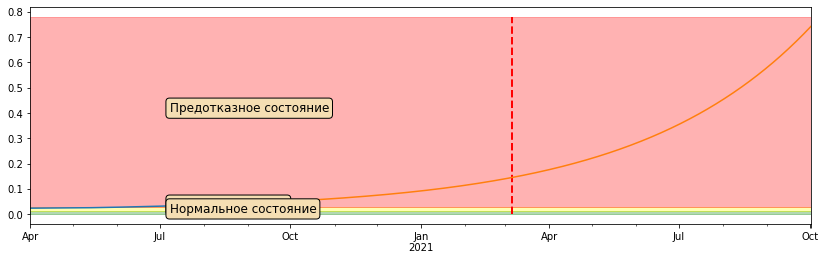

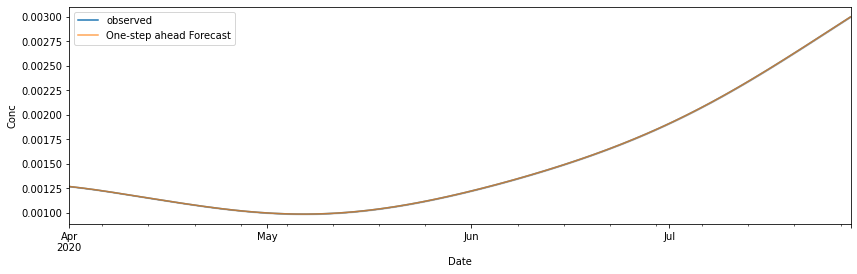

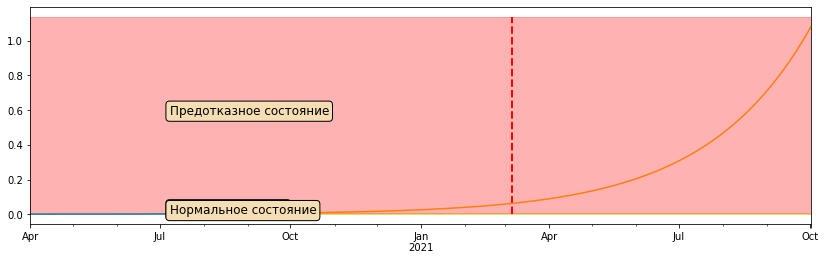

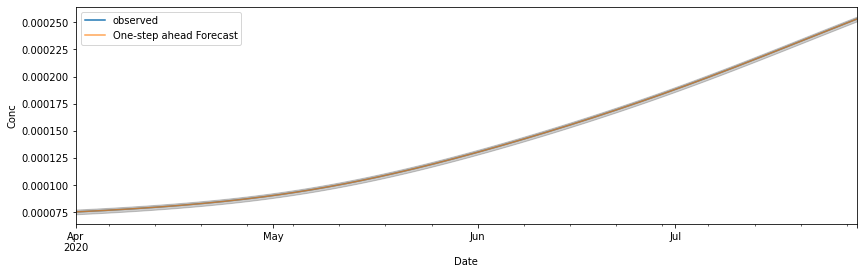

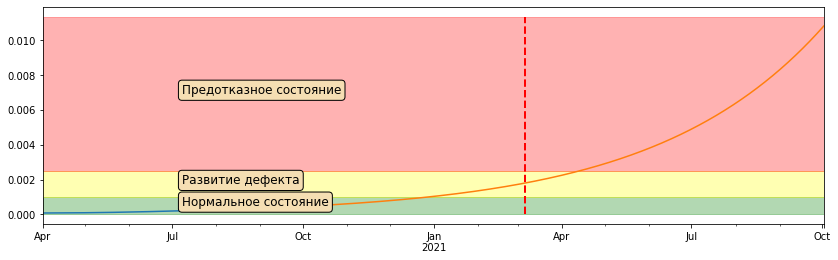

----------------------------------------------------
GAS H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 1.12e-08
----------------------------------------------------
GAS CO
The Mean Squared Error is 0.0
The Root Mean Squared Error is 1.883e-07
----------------------------------------------------
GAS C2H4
The Mean Squared Error is 0.0
The Root Mean Squared Error is 4.06e-08
----------------------------------------------------
GAS C2H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 1.04e-07


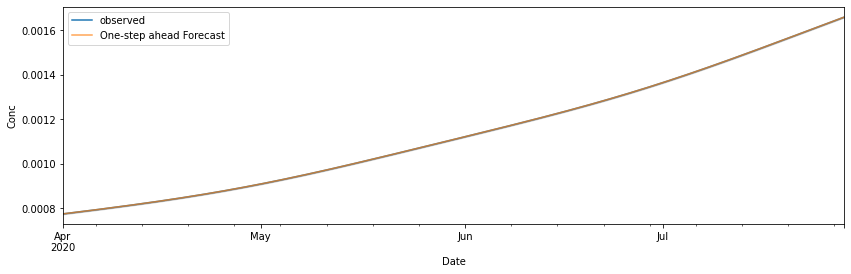

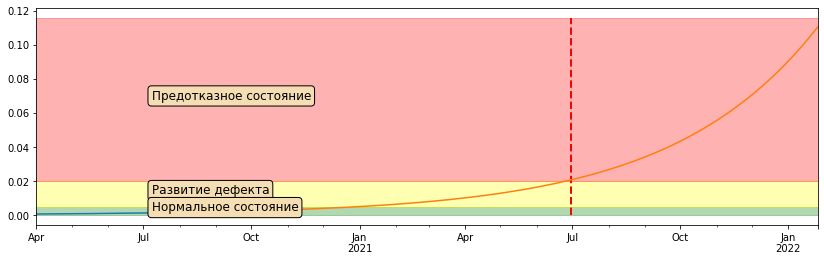

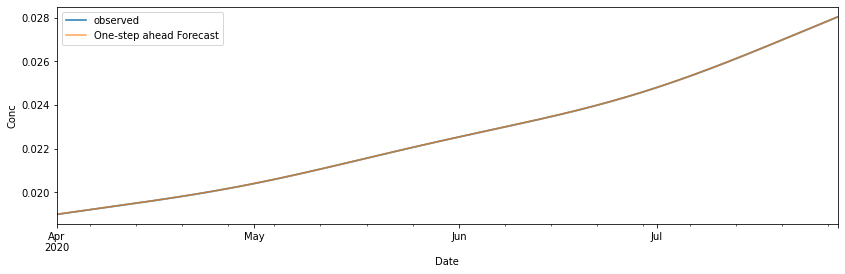

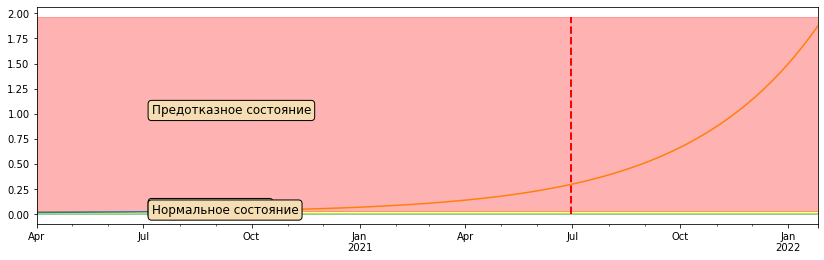

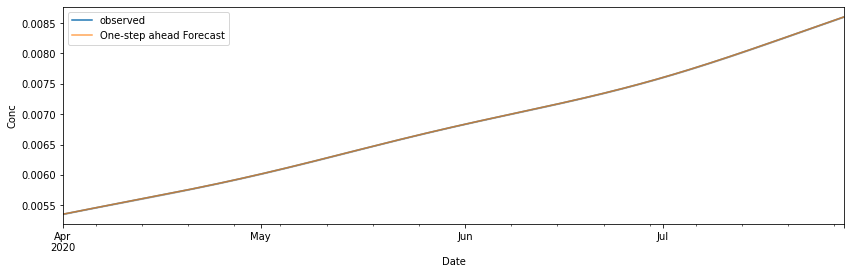

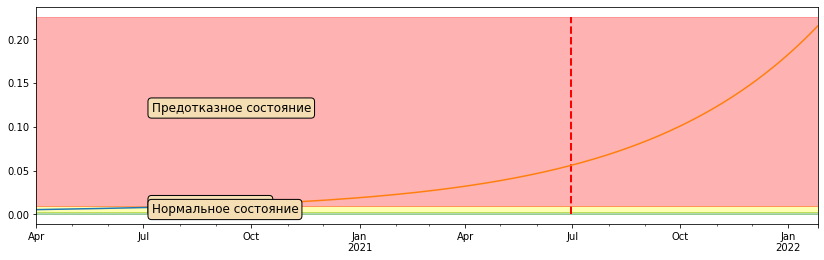

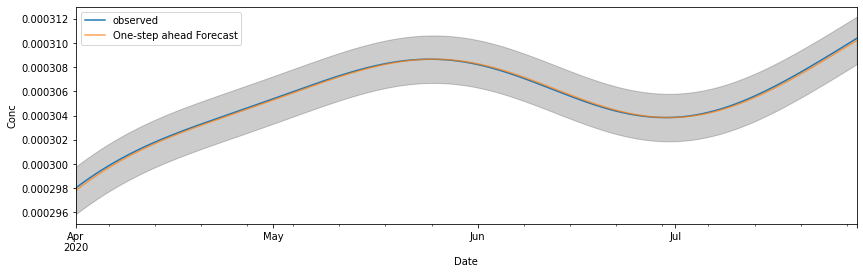

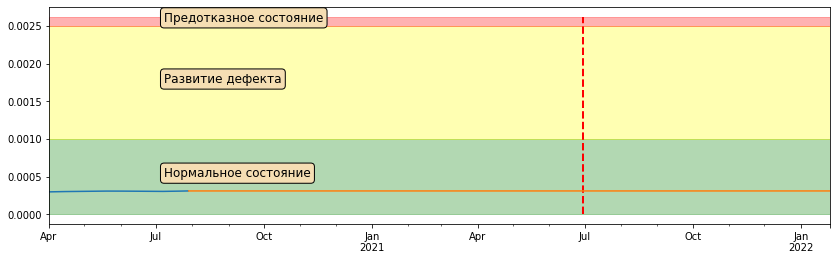

----------------------------------------------------
GAS H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 3.98e-08
----------------------------------------------------
GAS CO
The Mean Squared Error is 0.0
The Root Mean Squared Error is 1.97e-07
----------------------------------------------------
GAS C2H4
The Mean Squared Error is 0.0
The Root Mean Squared Error is 5.25e-08
----------------------------------------------------
GAS C2H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 1.4e-09


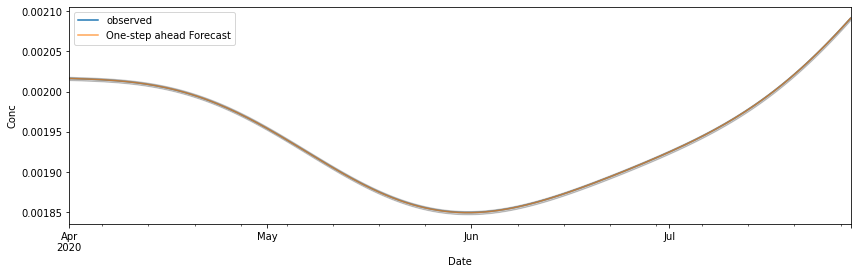

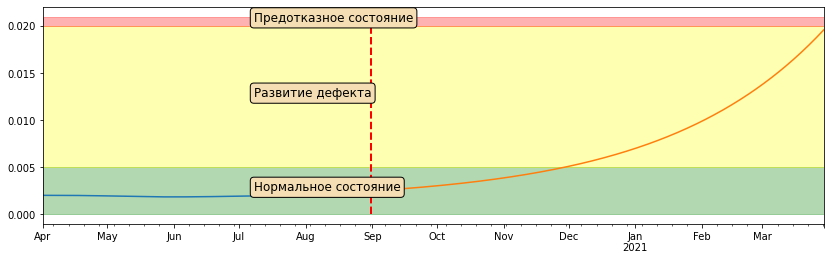

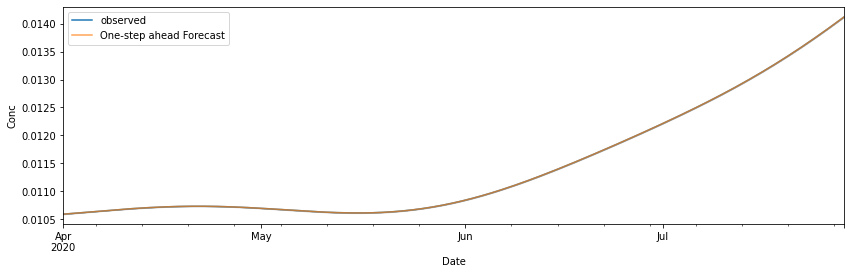

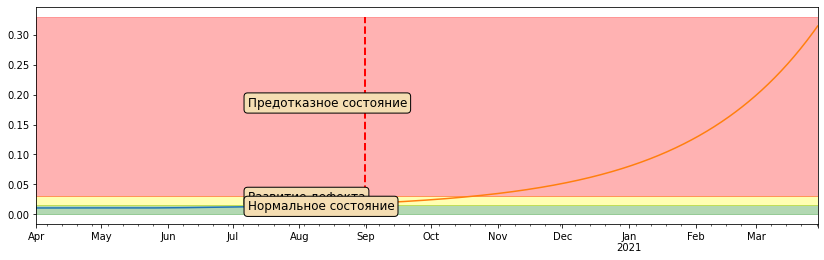

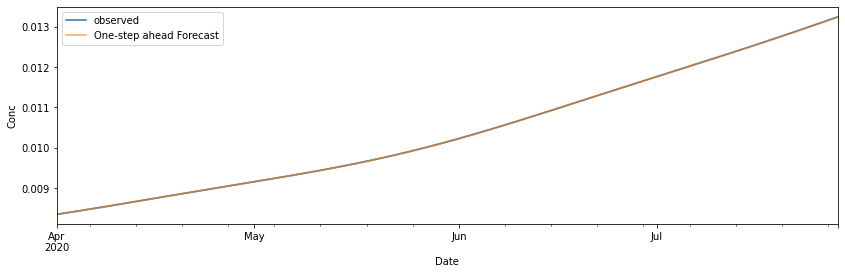

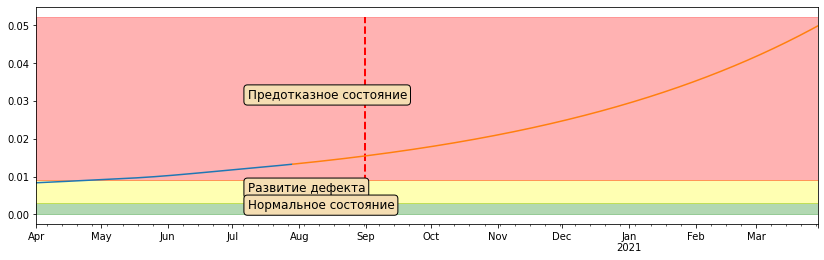

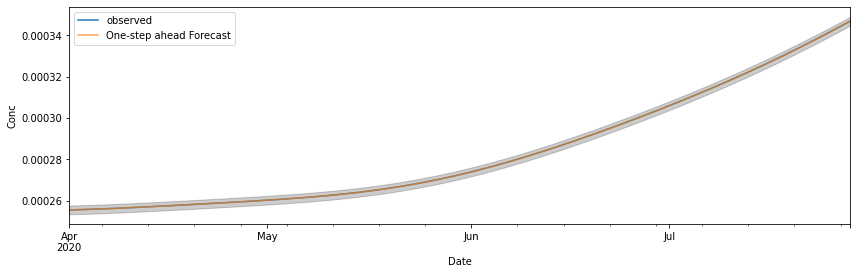

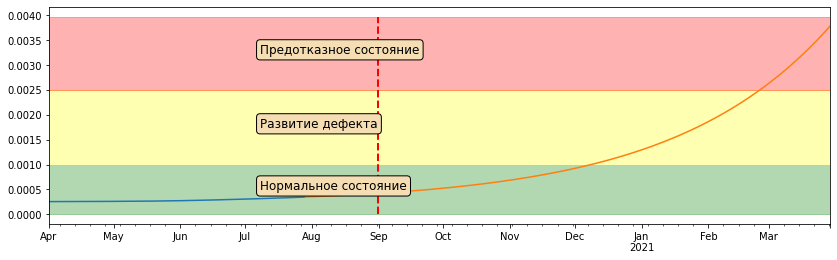

----------------------------------------------------
GAS H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 1.5049e-06
----------------------------------------------------
GAS CO
The Mean Squared Error is 0.0
The Root Mean Squared Error is 2.163e-07
----------------------------------------------------
GAS C2H4
The Mean Squared Error is 0.0
The Root Mean Squared Error is 1.383e-07
----------------------------------------------------
GAS C2H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 5.527e-07


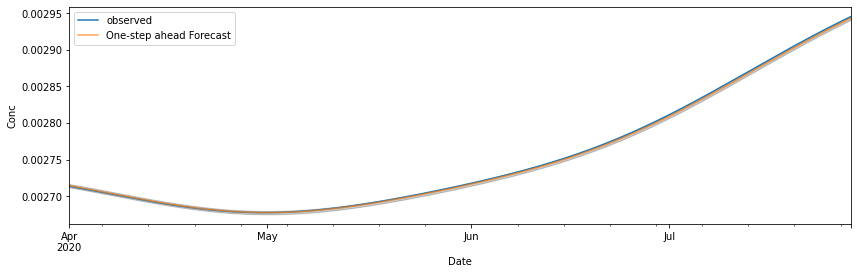

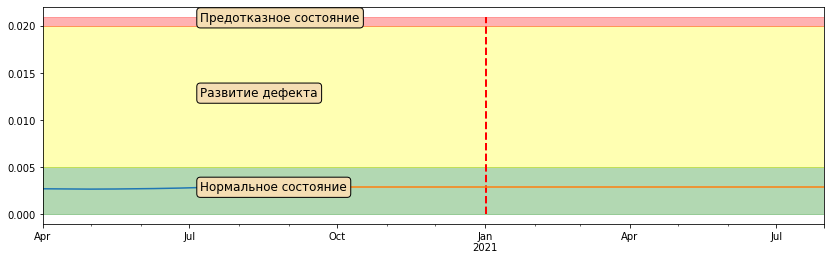

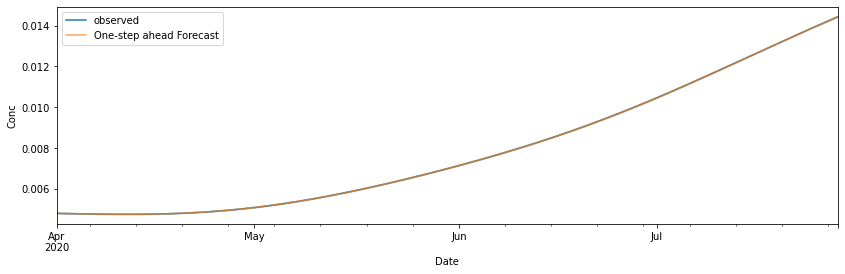

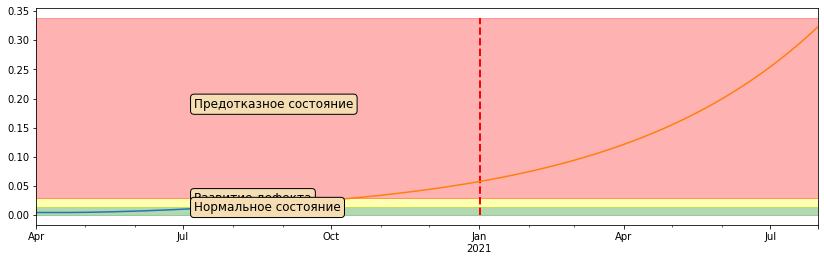

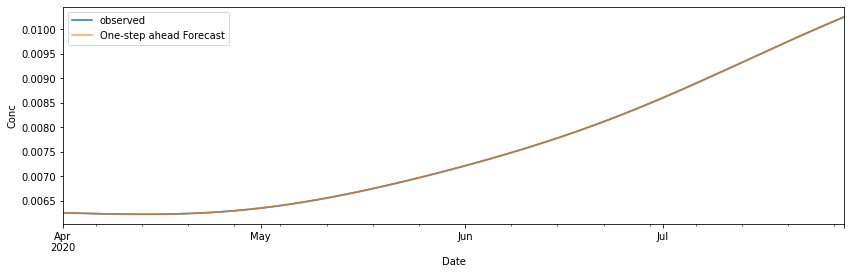

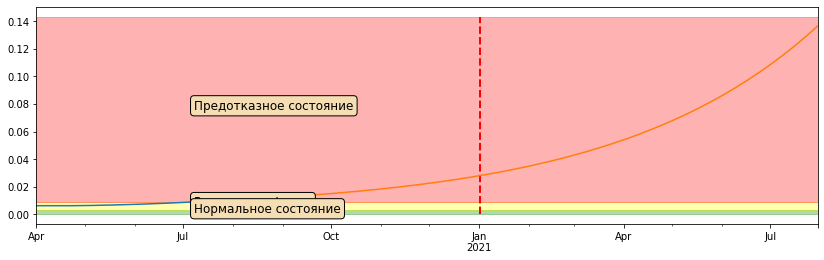

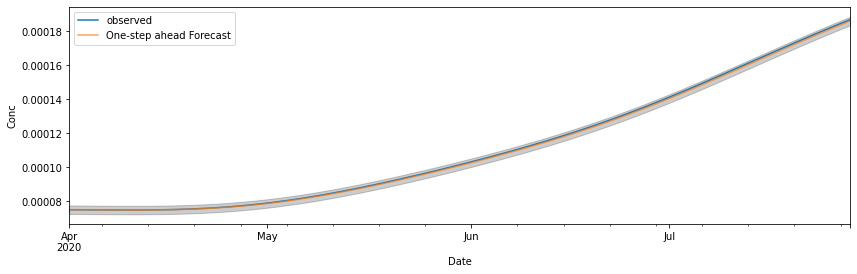

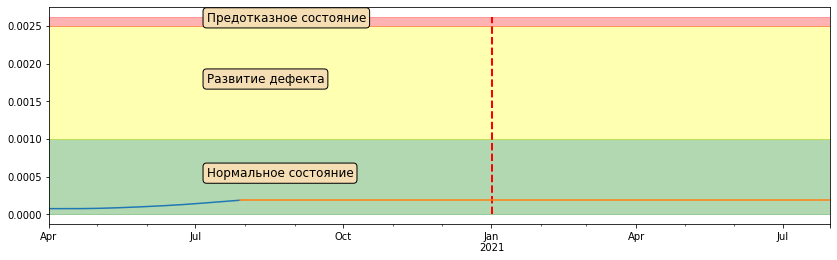

----------------------------------------------------
GAS H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 1.066e-07
----------------------------------------------------
GAS CO
The Mean Squared Error is 0.0
The Root Mean Squared Error is 3.514e-07
----------------------------------------------------
GAS C2H4
The Mean Squared Error is 0.0
The Root Mean Squared Error is 7.01e-08
----------------------------------------------------
GAS C2H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 4e-09


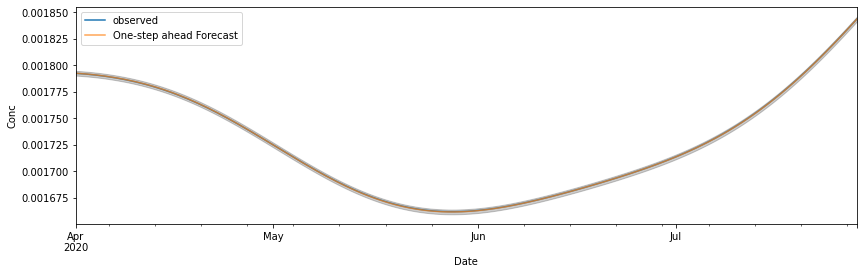

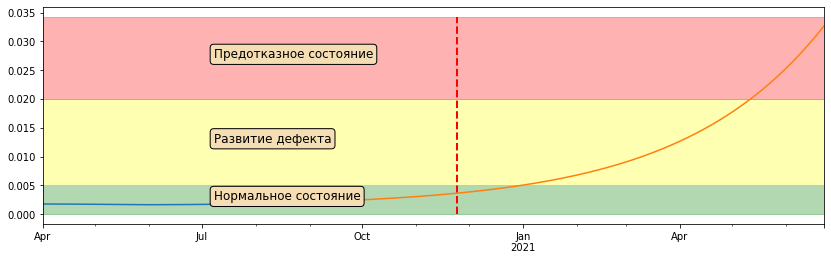

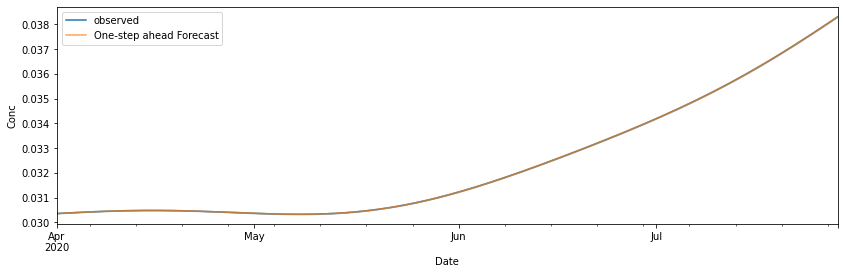

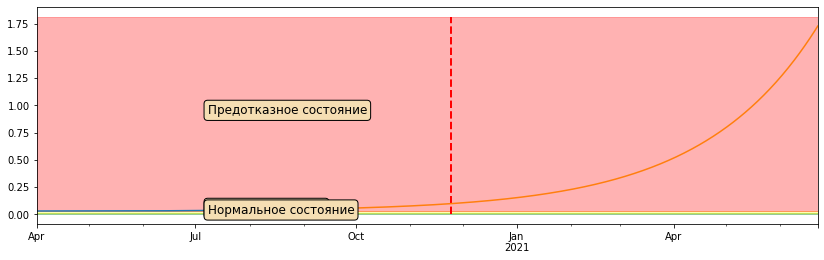

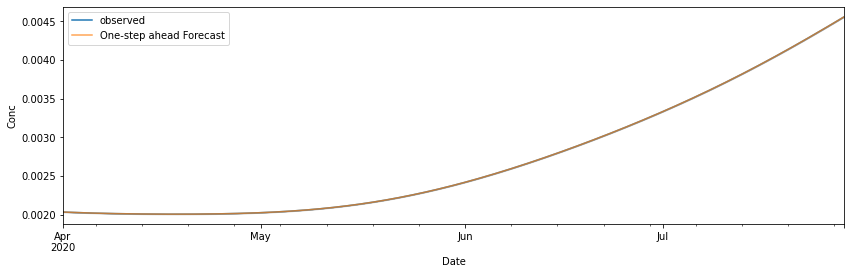

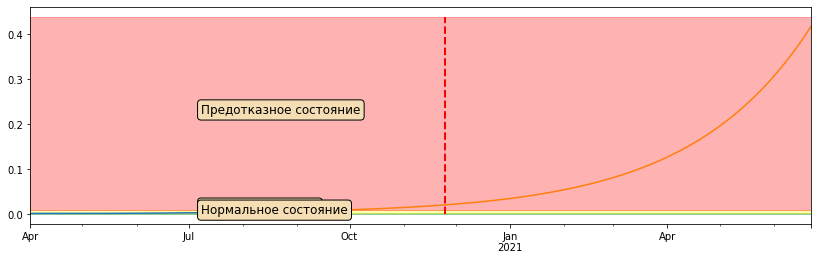

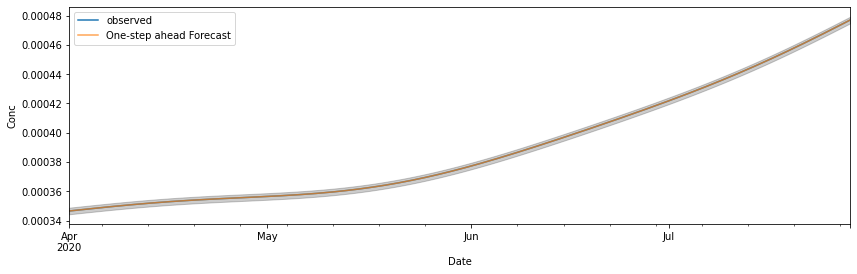

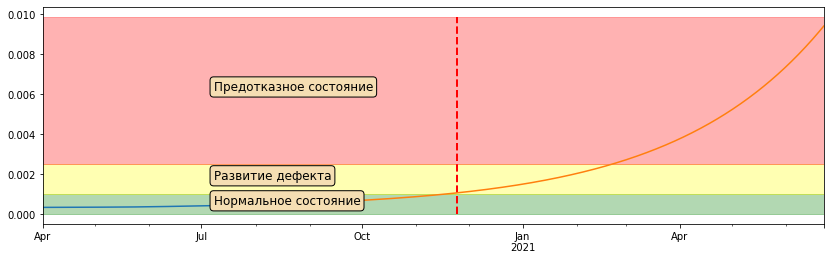

----------------------------------------------------
GAS H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 1.46e-08
----------------------------------------------------
GAS CO
The Mean Squared Error is 0.0
The Root Mean Squared Error is 5.571e-07
----------------------------------------------------
GAS C2H4
The Mean Squared Error is 0.0
The Root Mean Squared Error is 5.33e-08
----------------------------------------------------
GAS C2H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 6.54e-07


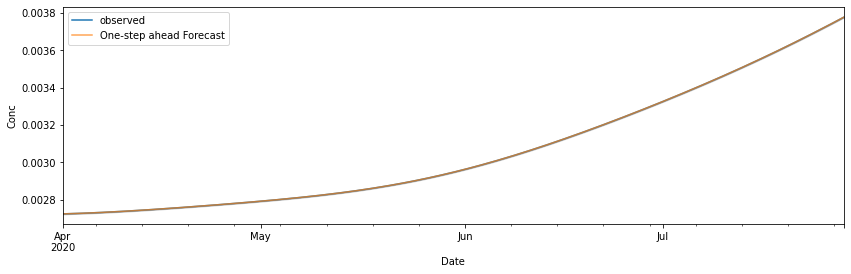

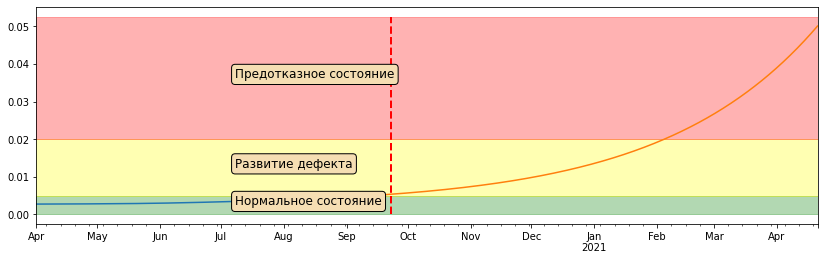

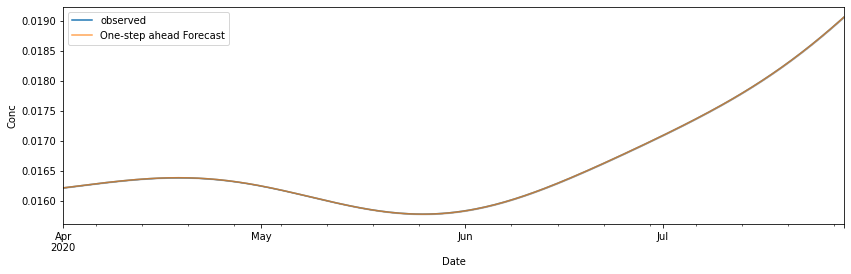

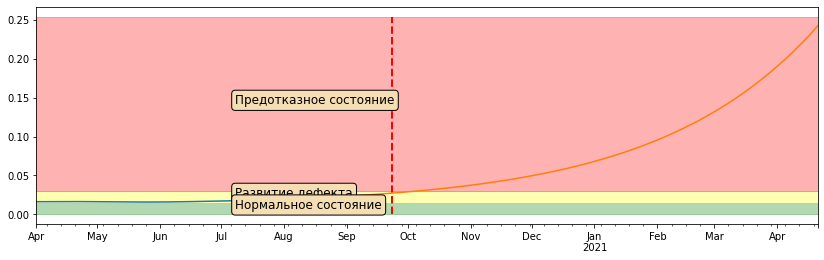

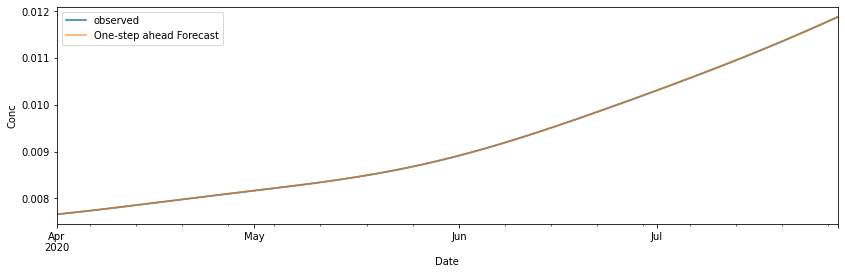

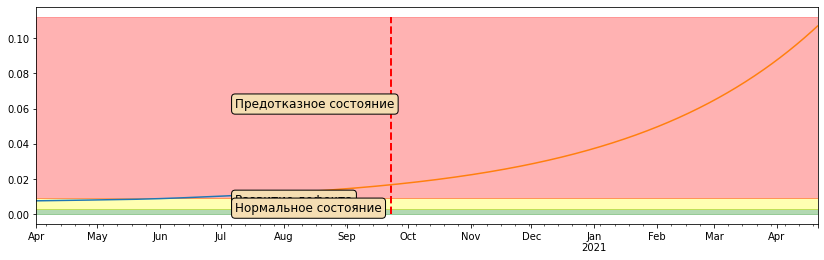

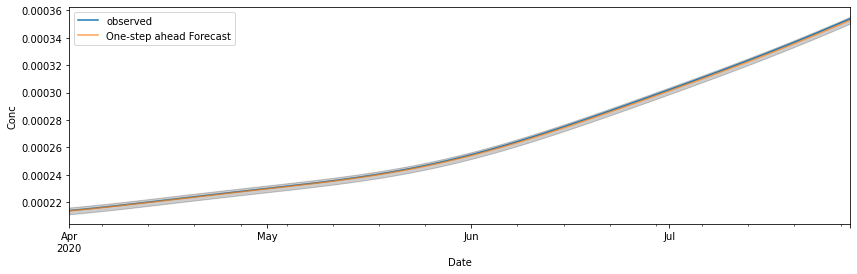

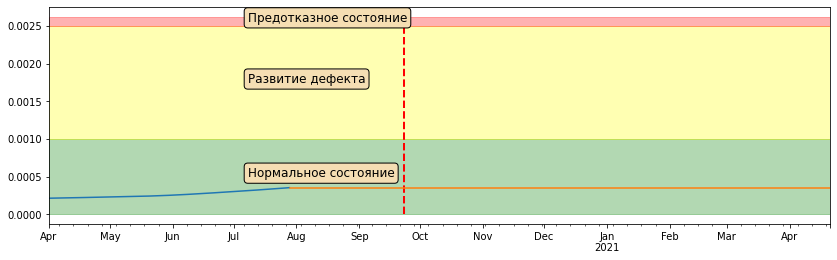

----------------------------------------------------
GAS H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 3.68e-08
----------------------------------------------------
GAS CO
The Mean Squared Error is 0.0
The Root Mean Squared Error is 5.626e-07
----------------------------------------------------
GAS C2H4
The Mean Squared Error is 0.0
The Root Mean Squared Error is 6.58e-08
----------------------------------------------------
GAS C2H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 3e-09


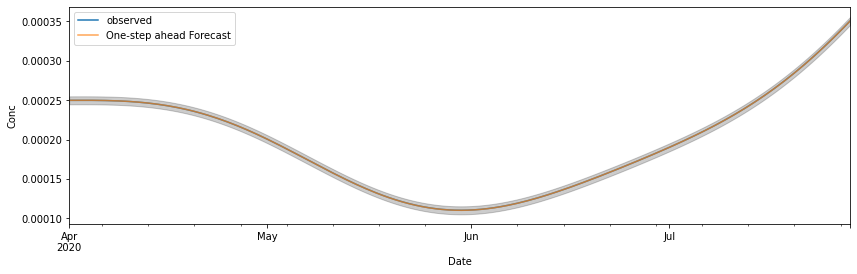

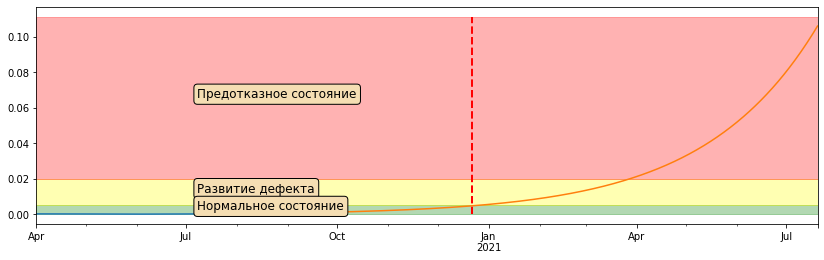

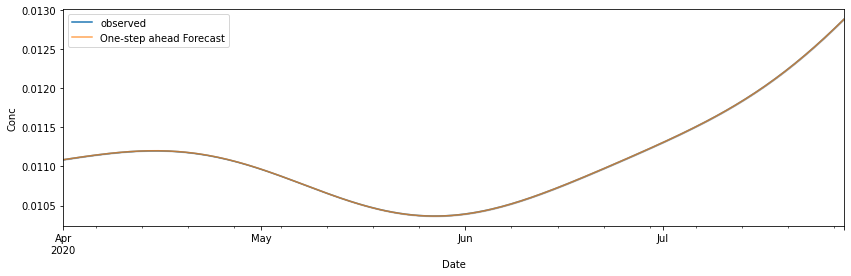

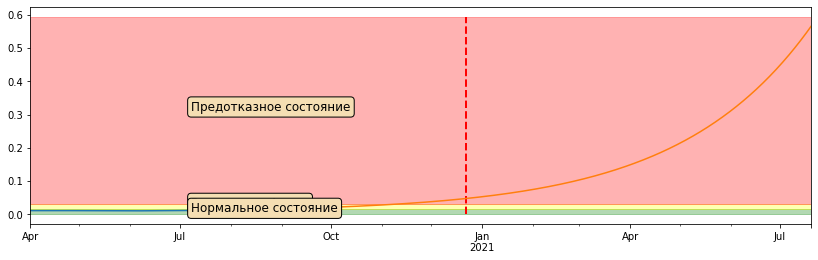

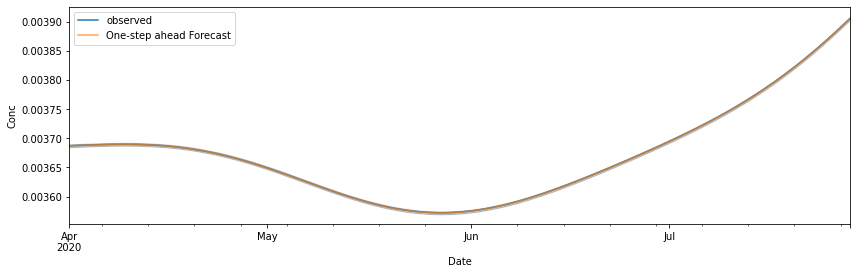

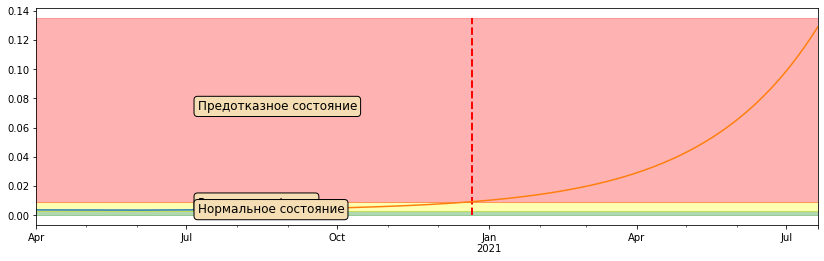

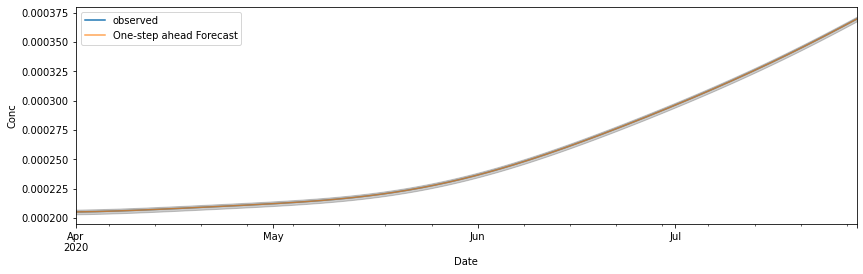

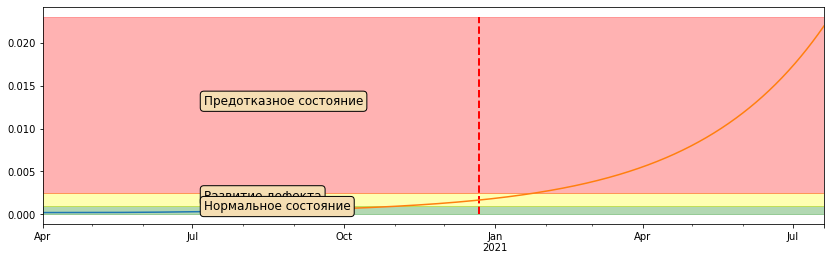

----------------------------------------------------
GAS H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 2.77e-08
----------------------------------------------------
GAS CO
The Mean Squared Error is 0.0
The Root Mean Squared Error is 2.642e-07
----------------------------------------------------
GAS C2H4
The Mean Squared Error is 0.0
The Root Mean Squared Error is 6.25e-08
----------------------------------------------------
GAS C2H2
The Mean Squared Error is 0.0
The Root Mean Squared Error is 3e-09


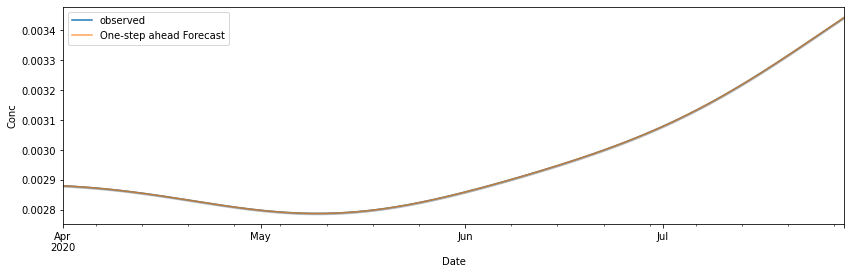

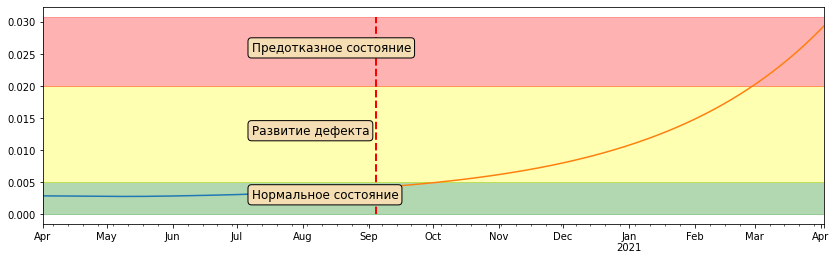

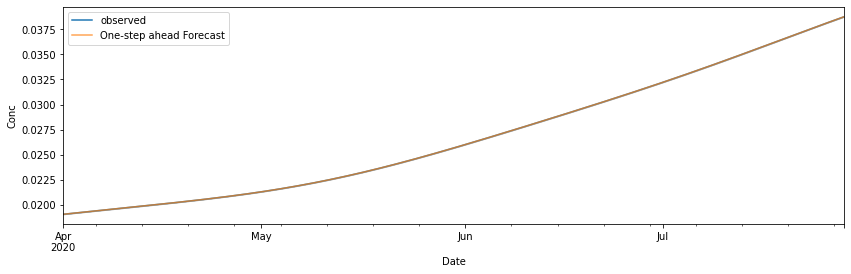

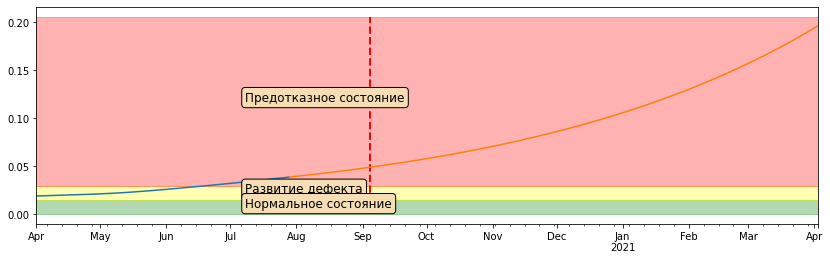

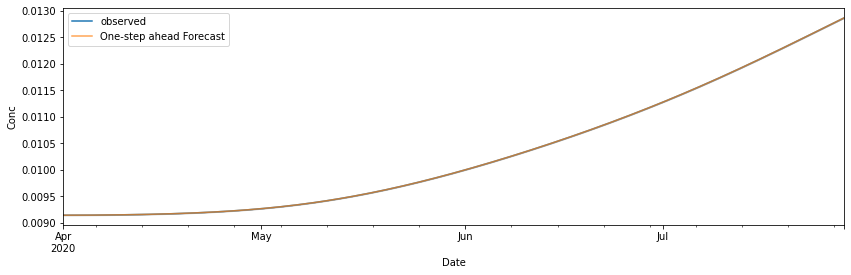

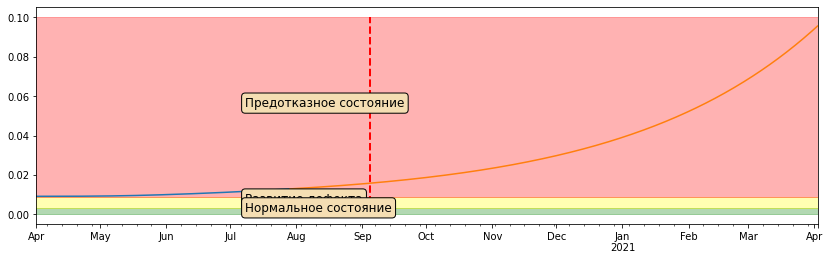

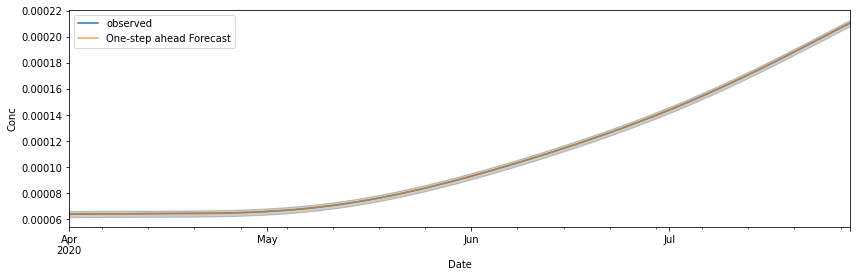

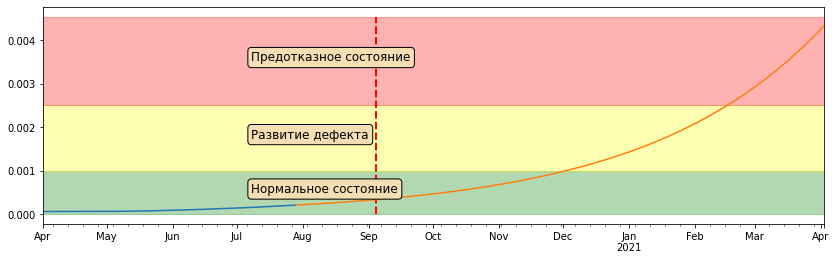

In [10]:
for file in data[:10]:
    models=funcs_for_proc.find_best_arima_model_for_gas(file)
    funcs_for_proc.plot_predict(file,models)
    plt.show()